<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/Learnable_Fourier_Features_NN_for_Shock_Wave_DSMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading all data variables...
Normalizing data...
Normalization successful.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features    │ (None, 128)       │         64 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 129)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        645 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,373 (196.77 KB)

 Trainable params: 50,373 (196.77 KB)

 Non-trainable params: 0 (0.00 B)


Starting training with learnable Fourier features...
Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1702 - val_loss: 0.1553
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1011 - val_loss: 0.0962
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0540 - val_loss: 0.0609
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0298 - val_loss: 0.0473
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0224 - val_loss: 0.0404
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0194 - val_loss: 0.0368
Epoch 7/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - val_loss: 0.0328
Epoch 8/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0160 - val_loss: 0.0296
Epoch 9/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - val_loss: 0.0243
Epoch 10/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - val_loss: 0.0202
Epoch 11/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - val_loss: 0.01

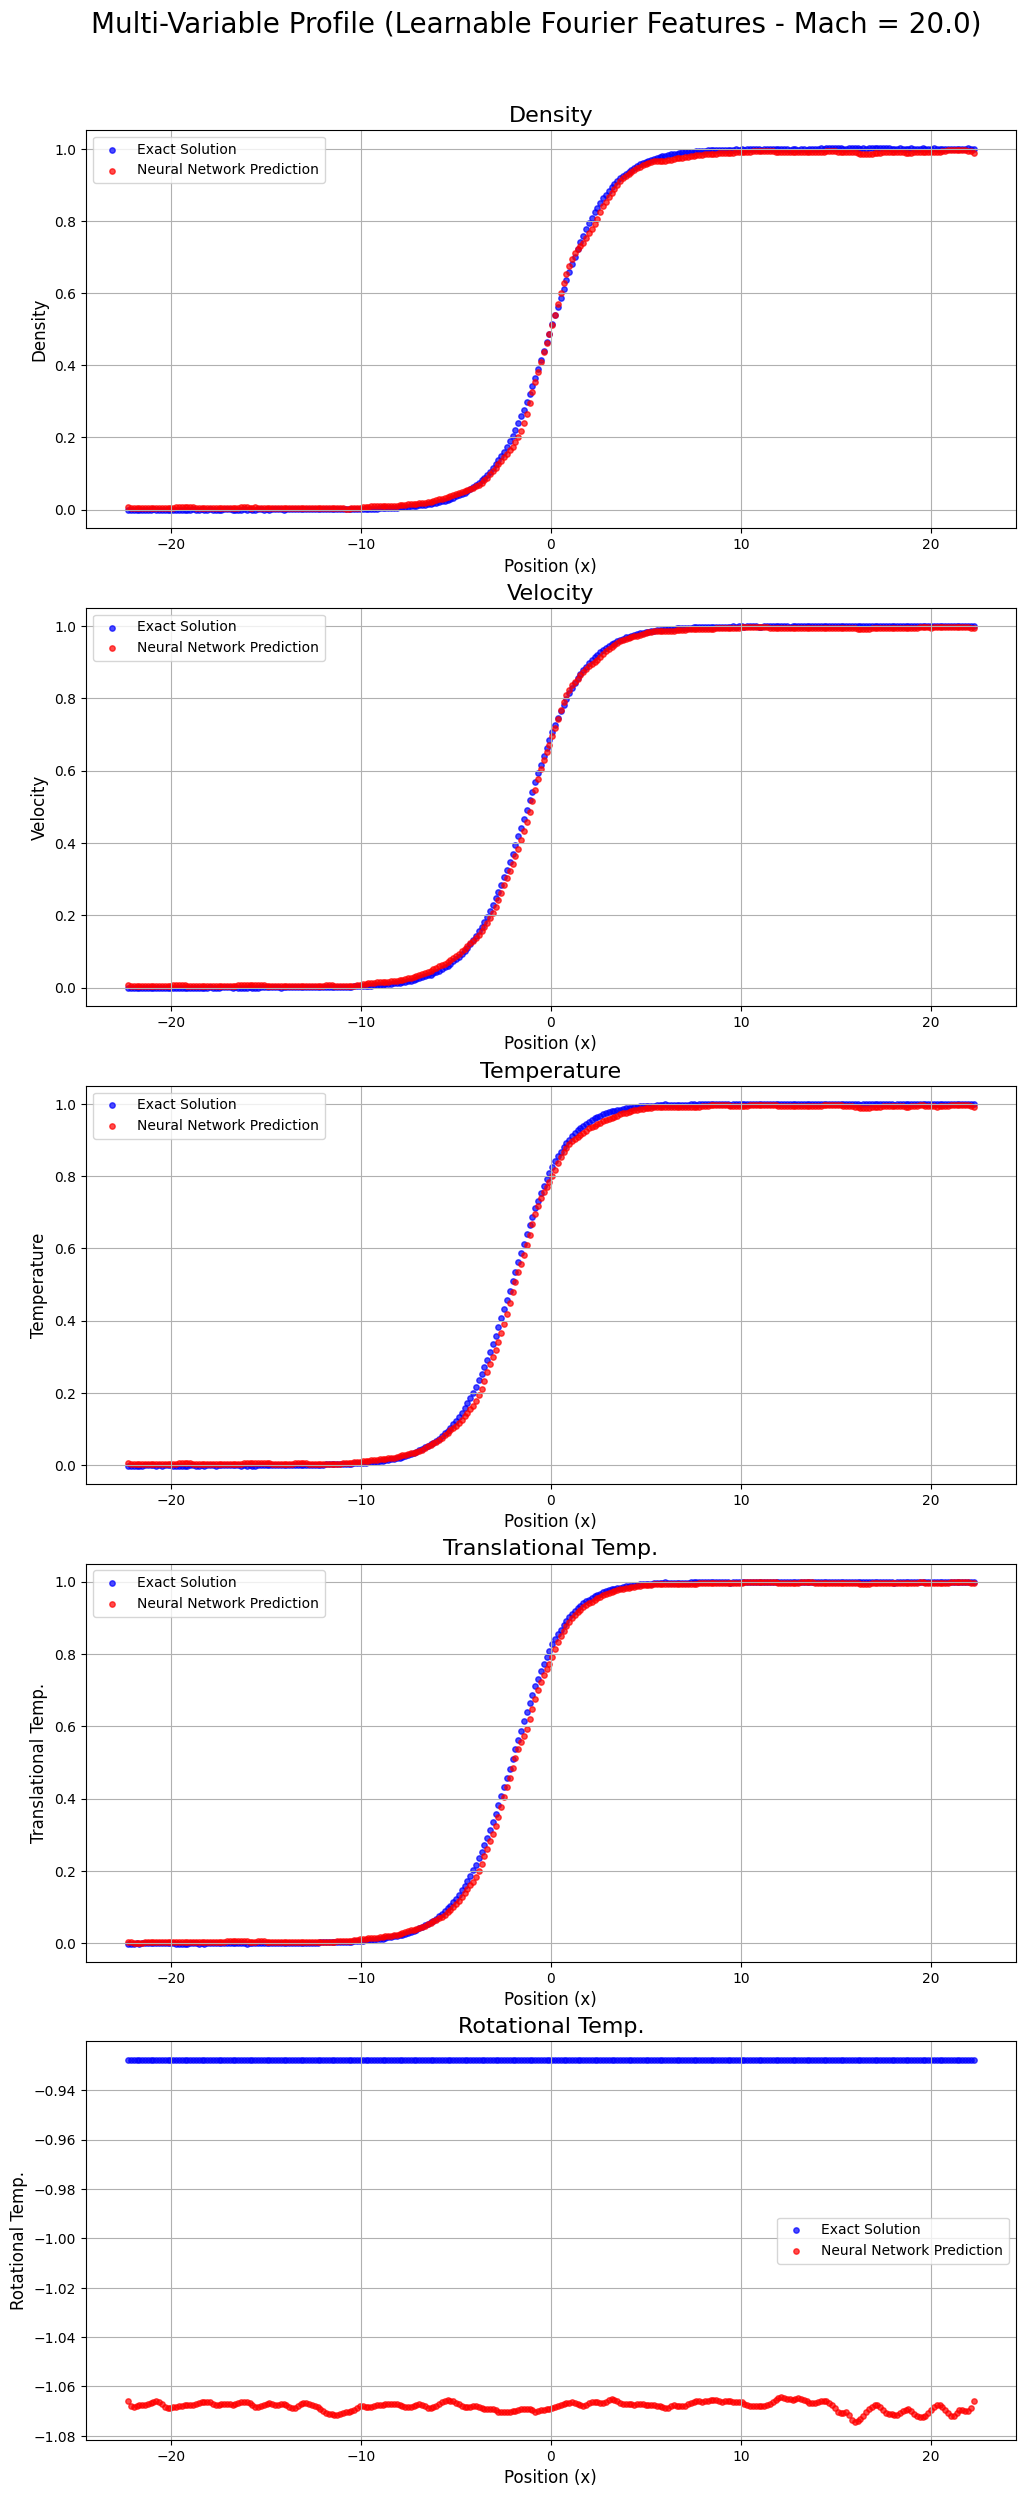

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

# --- 1. Learnable Fourier Feature Layer (Innovation) ---
# به جای کلاس قبلی، یک لایه سفارشی کراس می‌سازیم
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        # B را به عنوان یک وزن قابل آموزش تعریف می‌کنیم
        # توجه: ما فقط برای ورودی موقعیت (1 بعد) ویژگی فوریه می‌سازیم
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        # x ورودی موقعیت است
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading (No Changes) ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
test_file = 'M20.txt'
# (کد بارگذاری داده‌ها بدون تغییر باقی می‌ماند)
def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)
print("Loading all data variables...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_test, y_test, mach_test = load_data([test_file], DATASET_PATH)
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)
mach_test = mach_test.reshape(-1, 1)

# --- 3. Normalization (Applied before feature mapping) ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# نرمال‌سازی داده‌های ورودی و خروجی
x_train_scaled = pos_scaler.fit_transform(x_train)
x_test_scaled = pos_scaler.transform(x_test)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
mach_test_scaled = mach_scaler.transform(mach_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print("Normalization successful.")

# --- 4. Model Building with Learnable Fourier Features ---
# از مدل فانکشنال کراس برای ترکیب ورودی‌ها استفاده می‌کنیم
pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

# لایه ویژگی فوریه را روی ورودی موقعیت اعمال می‌کنیم
fourier_layer = FourierFeatures(output_dims=128)(pos_input)

# خروجی لایه فوریه را با ورودی عدد ماخ ترکیب می‌کنیم
concatenated_input = layers.concatenate([fourier_layer, mach_input])

# لایه‌های پنهان شبکه
x = layers.Dense(128, activation='tanh')(concatenated_input)
x = layers.Dense(128, activation='tanh')(x)
x = layers.Dense(128, activation='tanh')(x)
output = layers.Dense(5, activation='sigmoid')(x)

# ساخت مدل نهایی
model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
# ورودی مدل حالا یک دیکشنری است
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nStarting training with learnable Fourier features...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=1000,
    validation_split=0.2,
    verbose=1,
    batch_size=64 # استفاده از batch size می‌تواند به پایداری آموزش کمک کند
)
print("Training finished.")

# --- 6. Evaluation and Plotting ---
print("\nEvaluating and predicting...")
test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
loss = model.evaluate(test_inputs, y_test_scaled, verbose=0)
print(f"Mean Squared Error on Test Data (normalized): {loss:.6f}")

y_pred_scaled = model.predict(test_inputs)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

print("Plotting results...")
test_mach_number = mach_test[0, 0]
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

fig, axes = plt.subplots(5, 1, figsize=(12, 30))
fig.suptitle(f'Multi-Variable Profile (Learnable Fourier Features - Mach = {test_mach_number})', fontsize=20, y=0.92)

for i in range(5):
    ax = axes[i]
    ax.scatter(x_test, y_test[:, i], label='Exact Solution', color='blue', s=15, alpha=0.7)
    ax.scatter(x_test, y_pred[:, i], label='Neural Network Prediction', color='red', s=15, alpha=0.7)
    ax.set_title(output_labels[i], fontsize=16)
    ax.set_xlabel('Position (x)', fontsize=12)
    ax.set_ylabel(output_labels[i], fontsize=12)
    ax.legend()
    ax.grid(True)
plt.show()

Loading training data...
Normalizing data based on training set...
Normalization successful.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features    │ (None, 128)       │         64 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 129)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        645 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,373 (196.77 KB)

 Trainable params: 50,373 (196.77 KB)

 Non-trainable params: 0 (0.00 B)


Starting training with learnable Fourier features...
Epoch 1/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1788 - val_loss: 0.1546
Epoch 2/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1039 - val_loss: 0.0869
Epoch 3/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0508 - val_loss: 0.0546
Epoch 4/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0284 - val_loss: 0.0456
Epoch 5/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - val_loss: 0.0411
Epoch 6/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0194 - val_loss: 0.0379
Epoch 7/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0342
Epoch 8/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0160 - val_loss: 0.0314
Epoch 9/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - val_loss: 0.0267
Epoch 10/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133 - val_loss: 0.0229
Epoch 11/1500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.017

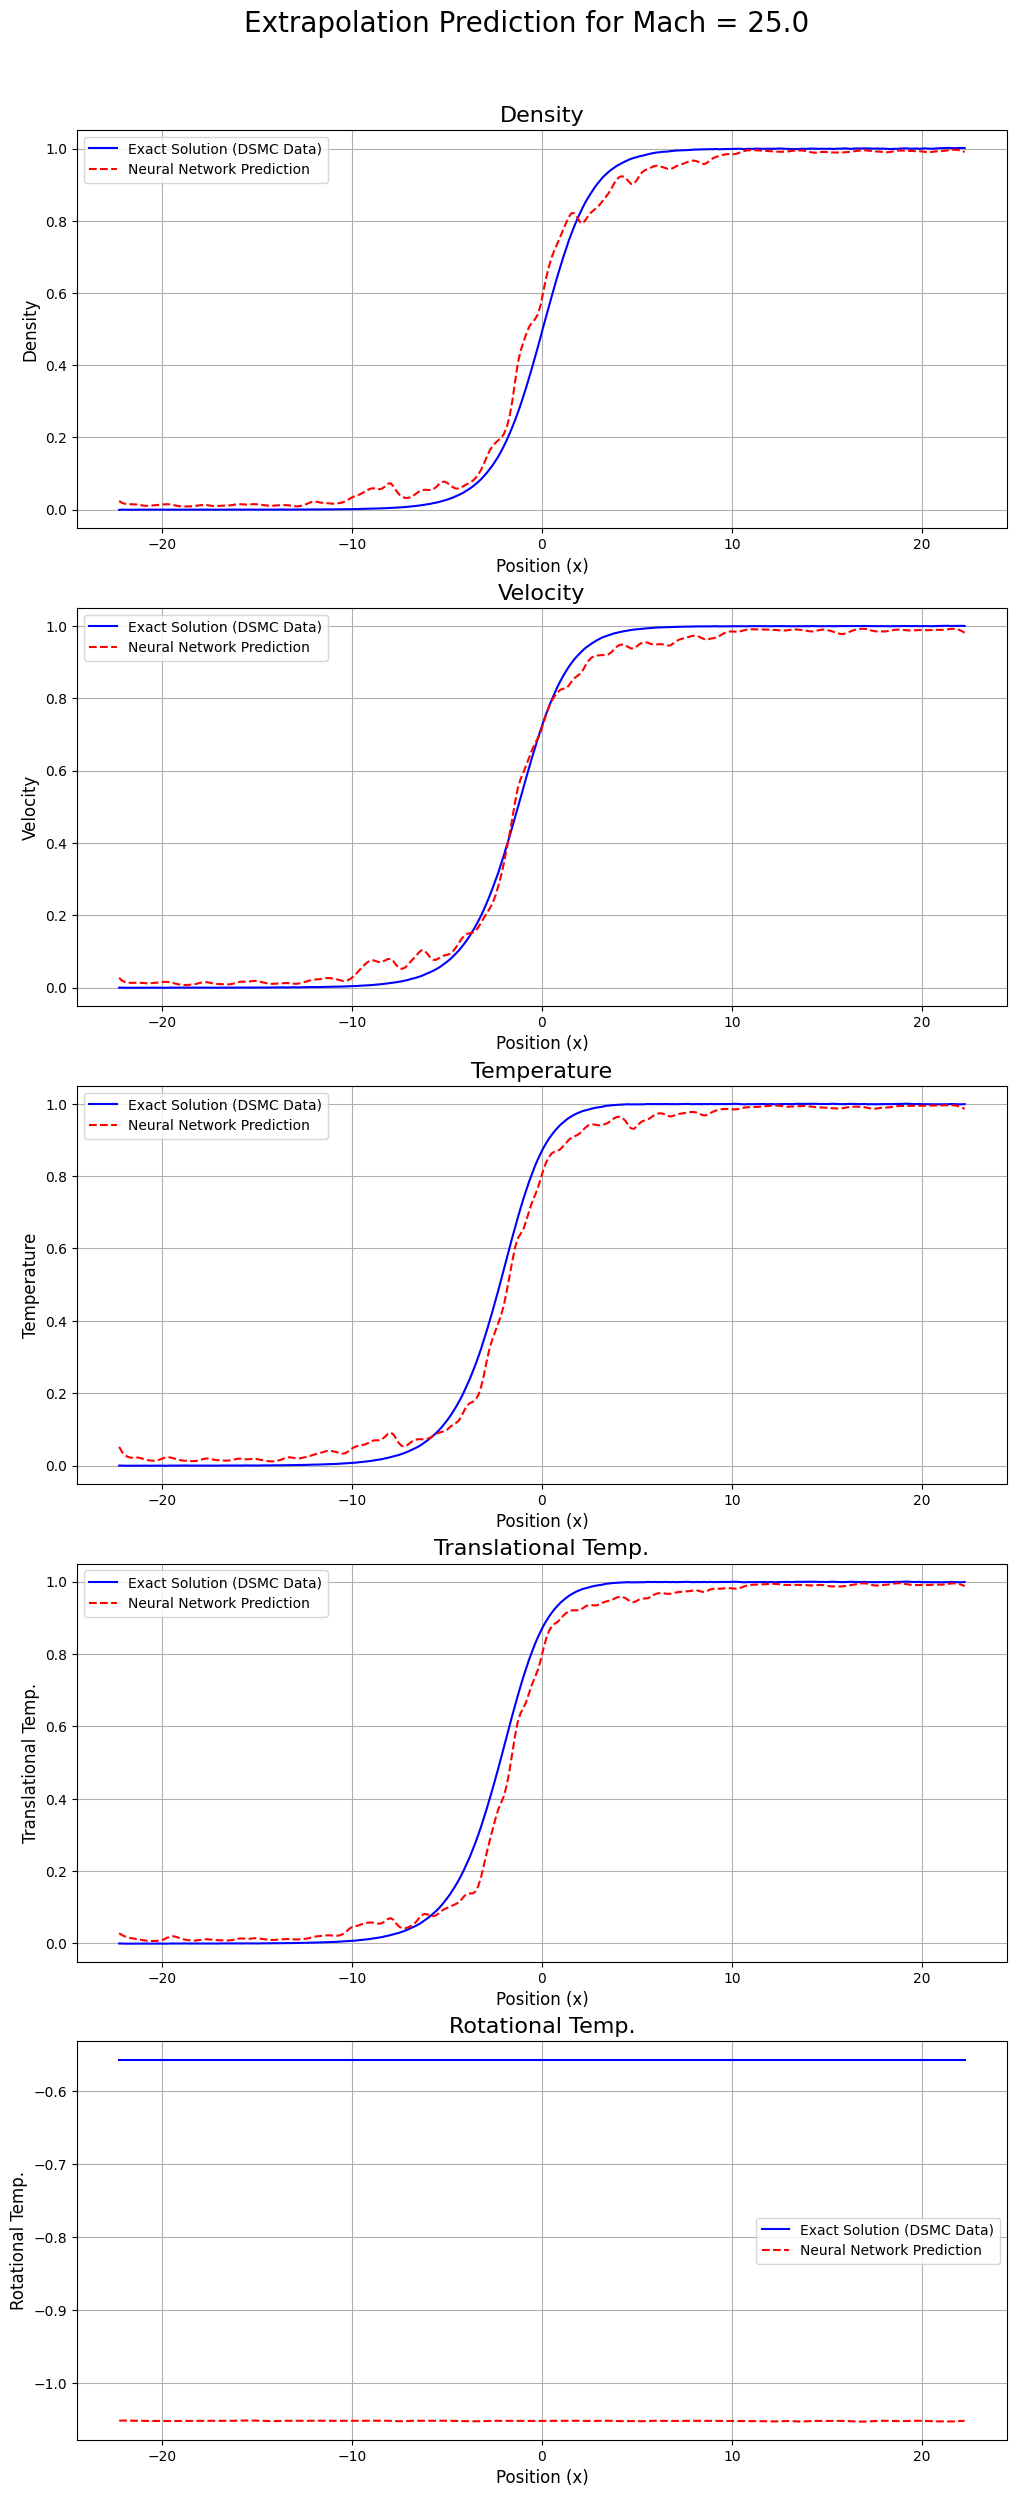


--- Evaluating for M30.txt ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Squared Error on Unscaled M30.txt Data: 0.094817


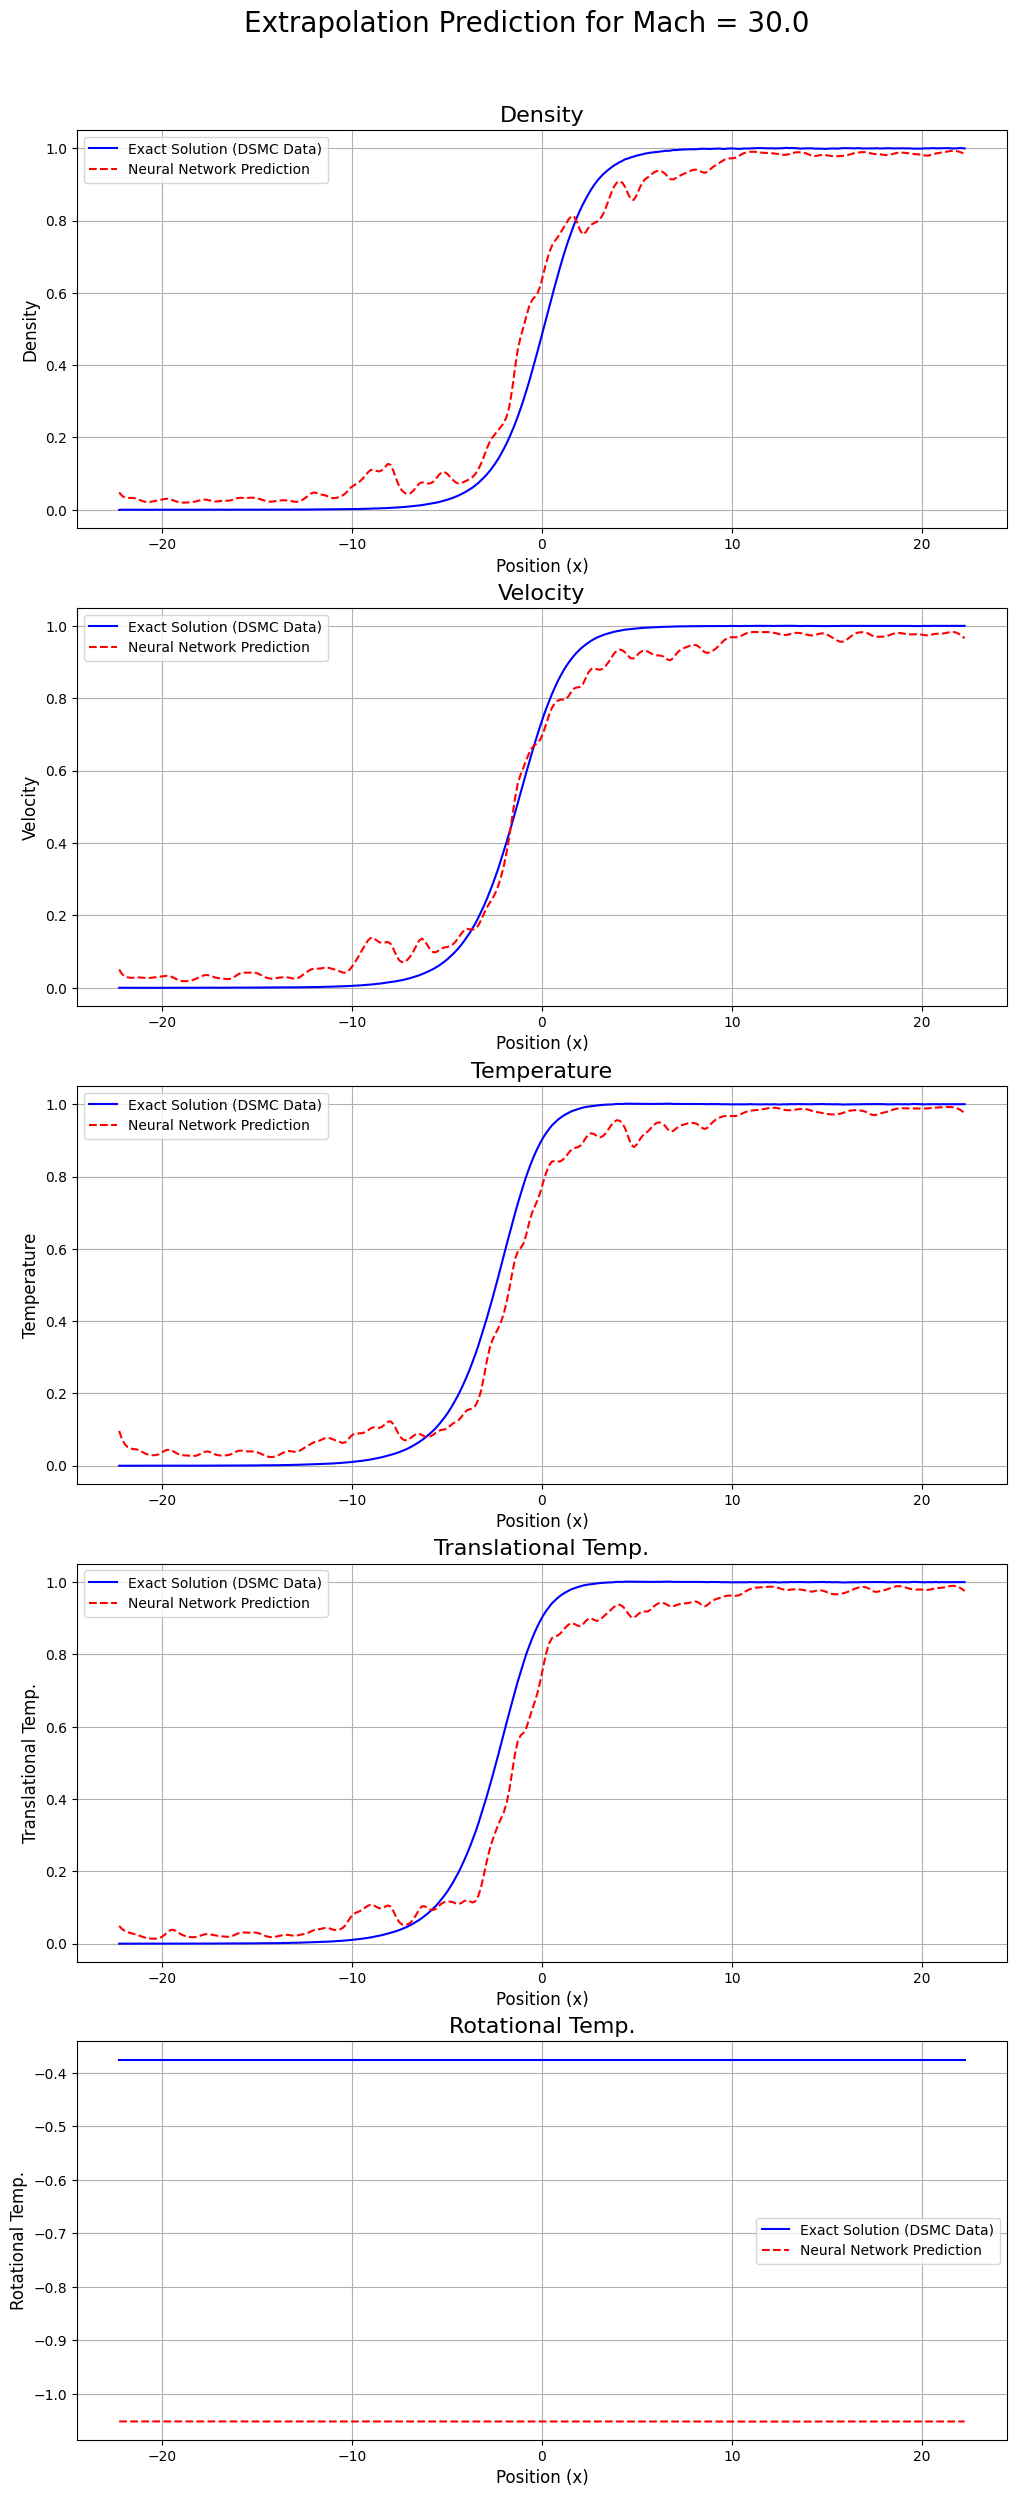

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

# --- 1. Learnable Fourier Feature Layer (No Changes) ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        # B is defined as a trainable weight
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        # x is the position input
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
# CHANGED: Updated test files for extrapolation
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_files = ['M25.txt', 'M30.txt'] # Test on Mach 25 and 30

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        # Check if file exists before trying to load
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            continue
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    if not x_data: # If no data was loaded
        return None, None, None
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
print("Normalizing data based on training set...")
pos_scaler = MinMaxScaler()
mach_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Fit scalers ONLY on the training data
x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")

# --- 4. Model Building with Learnable Fourier Features (No Changes) ---
pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

fourier_layer = FourierFeatures(output_dims=128)(pos_input)
concatenated_input = layers.concatenate([fourier_layer, mach_input])

x = layers.Dense(128, activation='tanh')(concatenated_input)
x = layers.Dense(128, activation='tanh')(x)
x = layers.Dense(128, activation='tanh')(x)
output = layers.Dense(5, activation='sigmoid')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training (No Changes) ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nStarting training with learnable Fourier features...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=1500, # Increased epochs for better convergence
    validation_split=0.2,
    verbose=1,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)]
)
print("Training finished.")

# --- 6. Evaluation and Plotting for Extrapolation ---
# CHANGED: Loop through each extrapolation file for separate evaluation
print("\n--- Starting Extrapolation Evaluation ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

for test_file in extrapolation_files:
    print(f"\n--- Evaluating for {test_file} ---")

    # Load the single test file data
    x_test, y_test, mach_test = load_data([test_file], DATASET_PATH)

    if x_test is None:
      continue

    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    # Scale test data using the scalers fitted on the training data
    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test) # Will produce values > 1, which is key for extrapolation

    # Prepare model inputs
    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}

    # Predict and inverse-transform the results
    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    # Calculate loss on the original (unscaled) data for interpretability
    test_loss_unscaled = np.mean((y_test - y_pred)**2)
    print(f"Mean Squared Error on Unscaled {test_file} Data: {test_loss_unscaled:.6f}")

    # Plotting results
    test_mach_number = mach_test[0, 0]
    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Extrapolation Prediction for Mach = {test_mach_number}', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        # Sort data by position for cleaner plotting if needed
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', label='Neural Network Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data for robust extrapolation...
Normalization successful.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_1  │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 257)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     66,048 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     65,792 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     65,792 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5)         │      1,285 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 264,837 (1.01 MB)

 Trainable params: 264,837 (1.01 MB)

 Non-trainable params: 0 (0.00 B)


Starting training with improved architecture...
Epoch 1/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.3790 - val_loss: 0.4513
Epoch 2/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.2341 - val_loss: 0.2455
Epoch 3/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1088 - val_loss: 0.0923
Epoch 4/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0460 - val_loss: 0.0524
Epoch 5/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0255 - val_loss: 0.0492
Epoch 6/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0208 - val_loss: 0.0407
Epoch 7/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0180 - val_loss: 0.0336
Epoch 8/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157 - val_loss: 0.0287
Epoch 9/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0142 - val_loss: 0.0247
Epoch 10/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0127 - val_loss: 0.0192
Epoch 11/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0113 - val_loss:

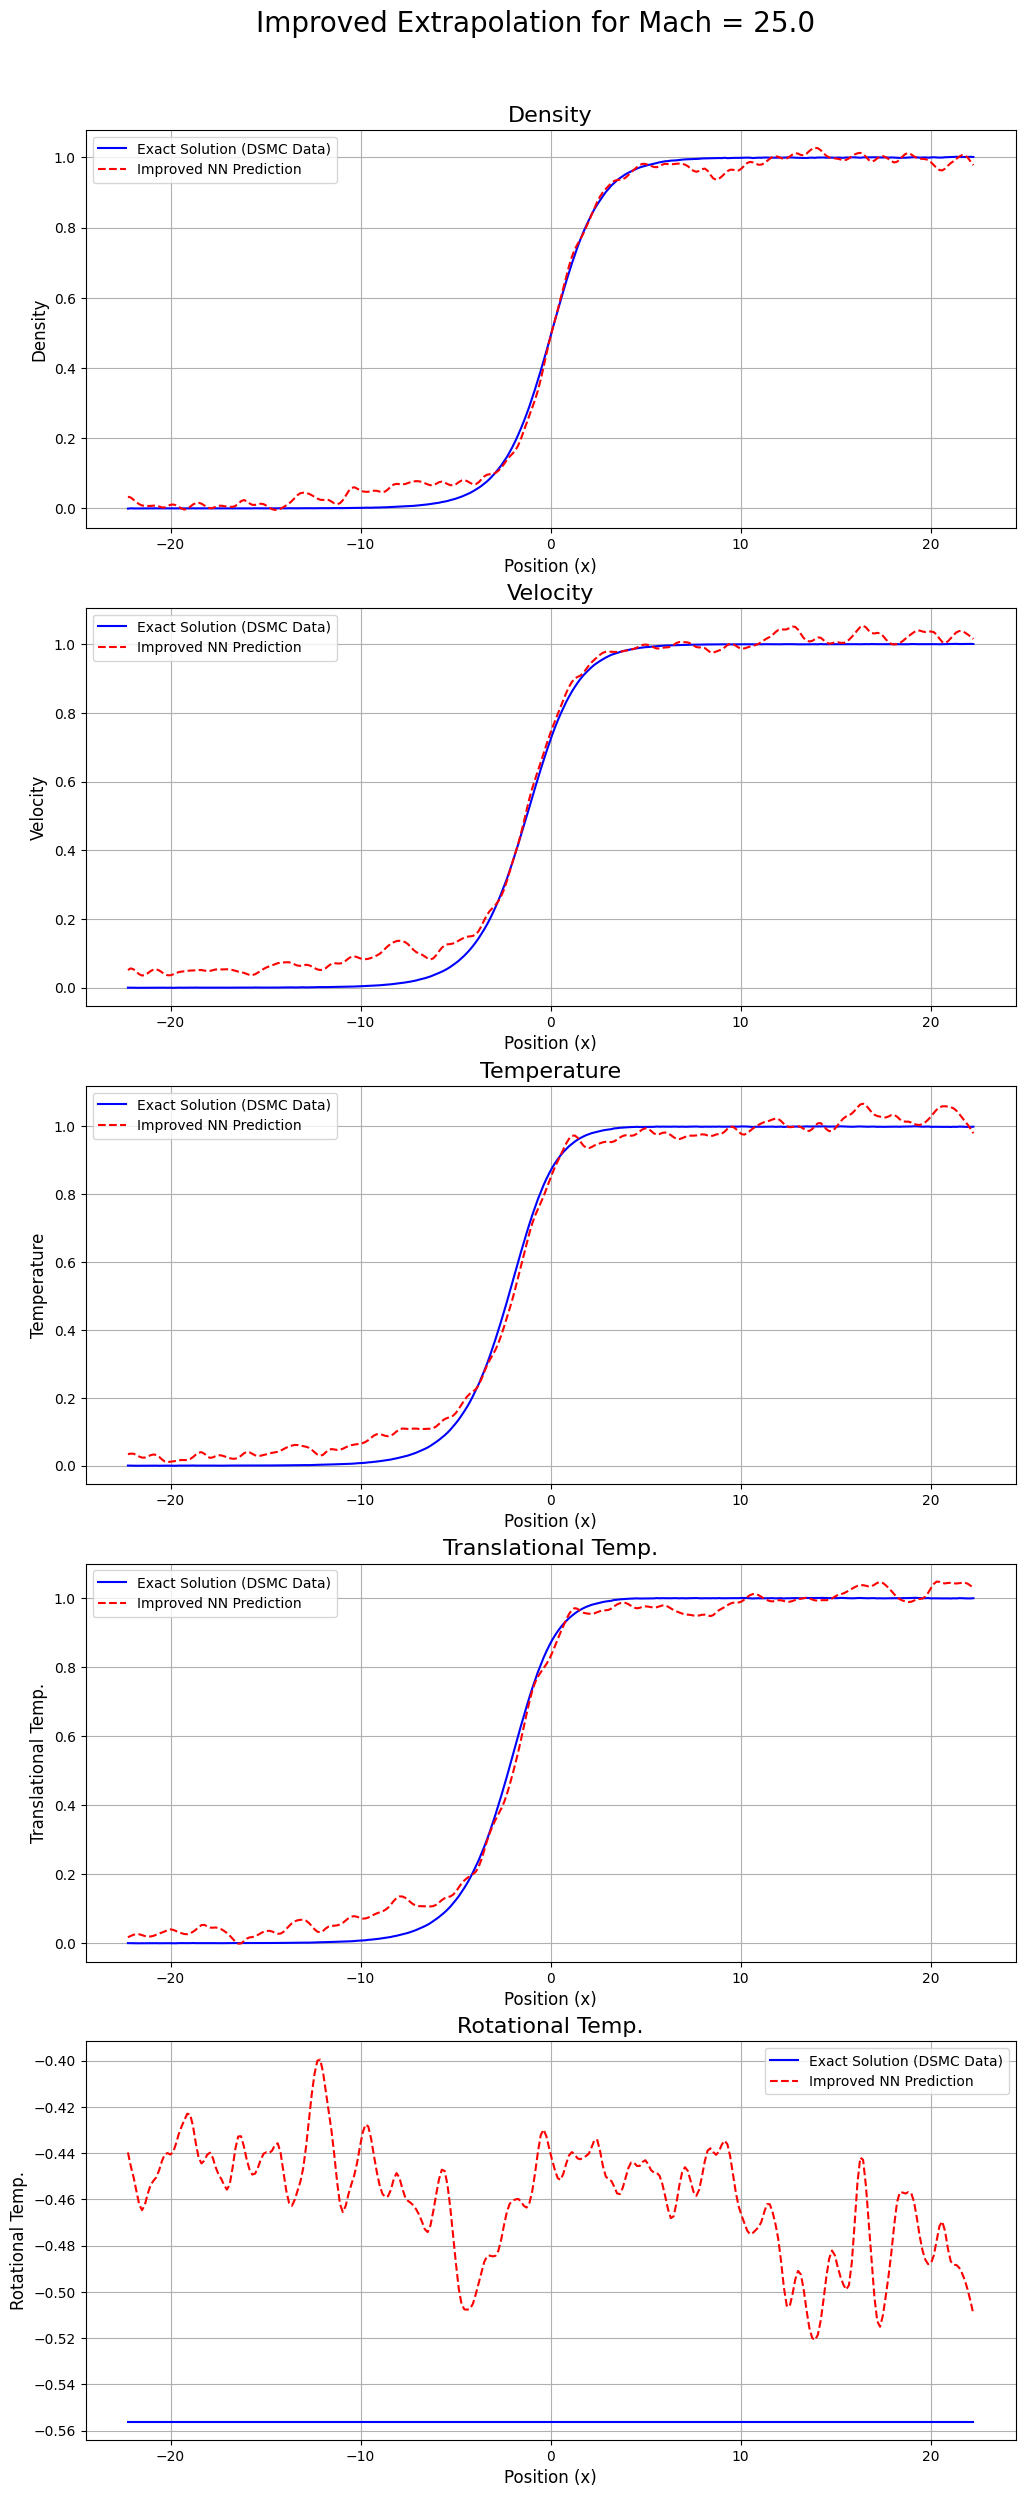


--- Evaluating for M30.txt ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error on Unscaled M30.txt Data: 0.017837


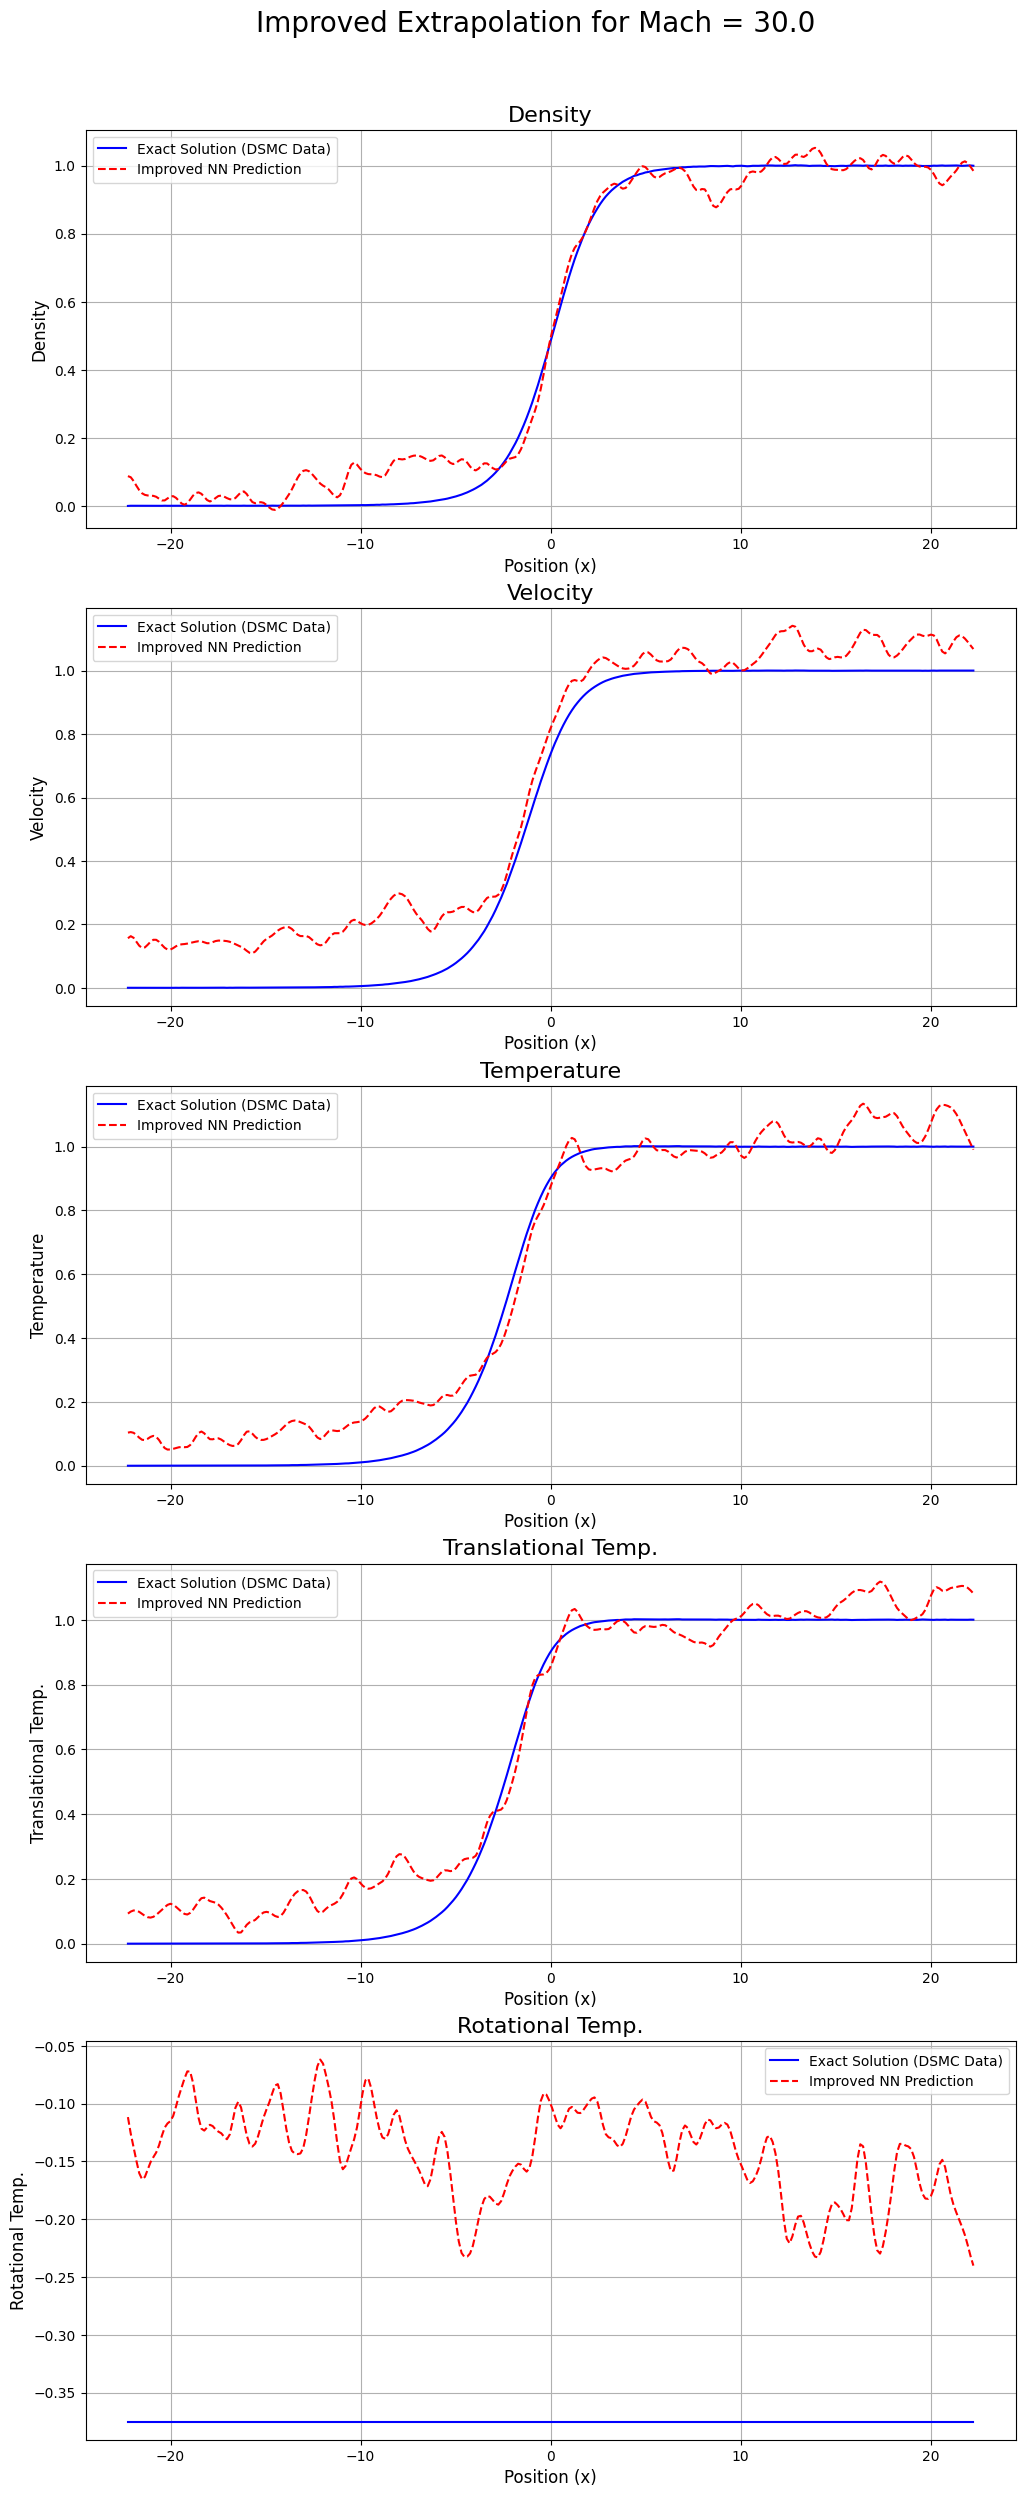

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
# CHANGED: Using StandardScaler for better extrapolation performance
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- 1. Learnable Fourier Feature Layer (No Changes) ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading (No Changes) ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_files = ['M25.txt', 'M30.txt']

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            continue
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    if not x_data:
        return None, None, None
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
# CHANGED: Using StandardScaler for Mach number and keeping MinMaxScaler for others
print("Normalizing data for robust extrapolation...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler() # Using StandardScaler for Mach
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")


# --- 4. Model Building with Improvements ---
# CHANGED: Deeper architecture and 'swish' activation function
pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

fourier_layer = FourierFeatures(output_dims=256)(pos_input) # Increased feature dimensions
concatenated_input = layers.concatenate([fourier_layer, mach_input])

# Deeper network with swish activation
x = layers.Dense(256, activation='swish')(concatenated_input)
x = layers.Dense(256, activation='swish')(x)
x = layers.Dense(256, activation='swish')(x)
x = layers.Dense(256, activation='swish')(x) # Added one more layer
output = layers.Dense(5, activation='linear')(x) # Using linear activation before scaling

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4) # Slightly lower learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
# CHANGED: Increased patience for EarlyStopping
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nStarting training with improved architecture...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=2500, # Increased epochs
    validation_split=0.2,
    verbose=1,
    batch_size=128, # Larger batch size for stability
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)]
)
print("Training finished.")


# --- 6. Evaluation and Plotting for Extrapolation (No Changes in Logic) ---
print("\n--- Starting Extrapolation Evaluation ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

for test_file in extrapolation_files:
    print(f"\n--- Evaluating for {test_file} ---")
    x_test, y_test, mach_test = load_data([test_file], DATASET_PATH)
    if x_test is None:
      continue
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}

    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    test_loss_unscaled = np.mean((y_test - y_pred)**2)
    print(f"Mean Squared Error on Unscaled {test_file} Data: {test_loss_unscaled:.6f}")

    test_mach_number = mach_test[0, 0]
    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Improved Extrapolation for Mach = {test_mach_number}', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', label='Improved NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data for robust extrapolation...
Normalization successful.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_2  │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 257)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     66,048 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     65,792 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │     65,792 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │     65,792 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 5)         │      1,285 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 264,837 (1.01 MB)

 Trainable params: 264,709 (1.01 MB)

 Non-trainable params: 128 (512.00 B)


Starting training with FIXED Fourier features for stability...
Epoch 1/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.4113 - val_loss: 0.4741
Epoch 2/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2836 - val_loss: 0.2960
Epoch 3/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1591 - val_loss: 0.1298
Epoch 4/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0702 - val_loss: 0.0579
Epoch 5/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0378 - val_loss: 0.0469
Epoch 6/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0221 - val_loss: 0.0460
Epoch 7/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - val_loss: 0.0311
Epoch 8/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0155 - val_loss: 0.0245
Epoch 9/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0130 - val_loss: 0.0220
Epoch 10/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0115 - val_loss: 0.0138
Epoch 11/2500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

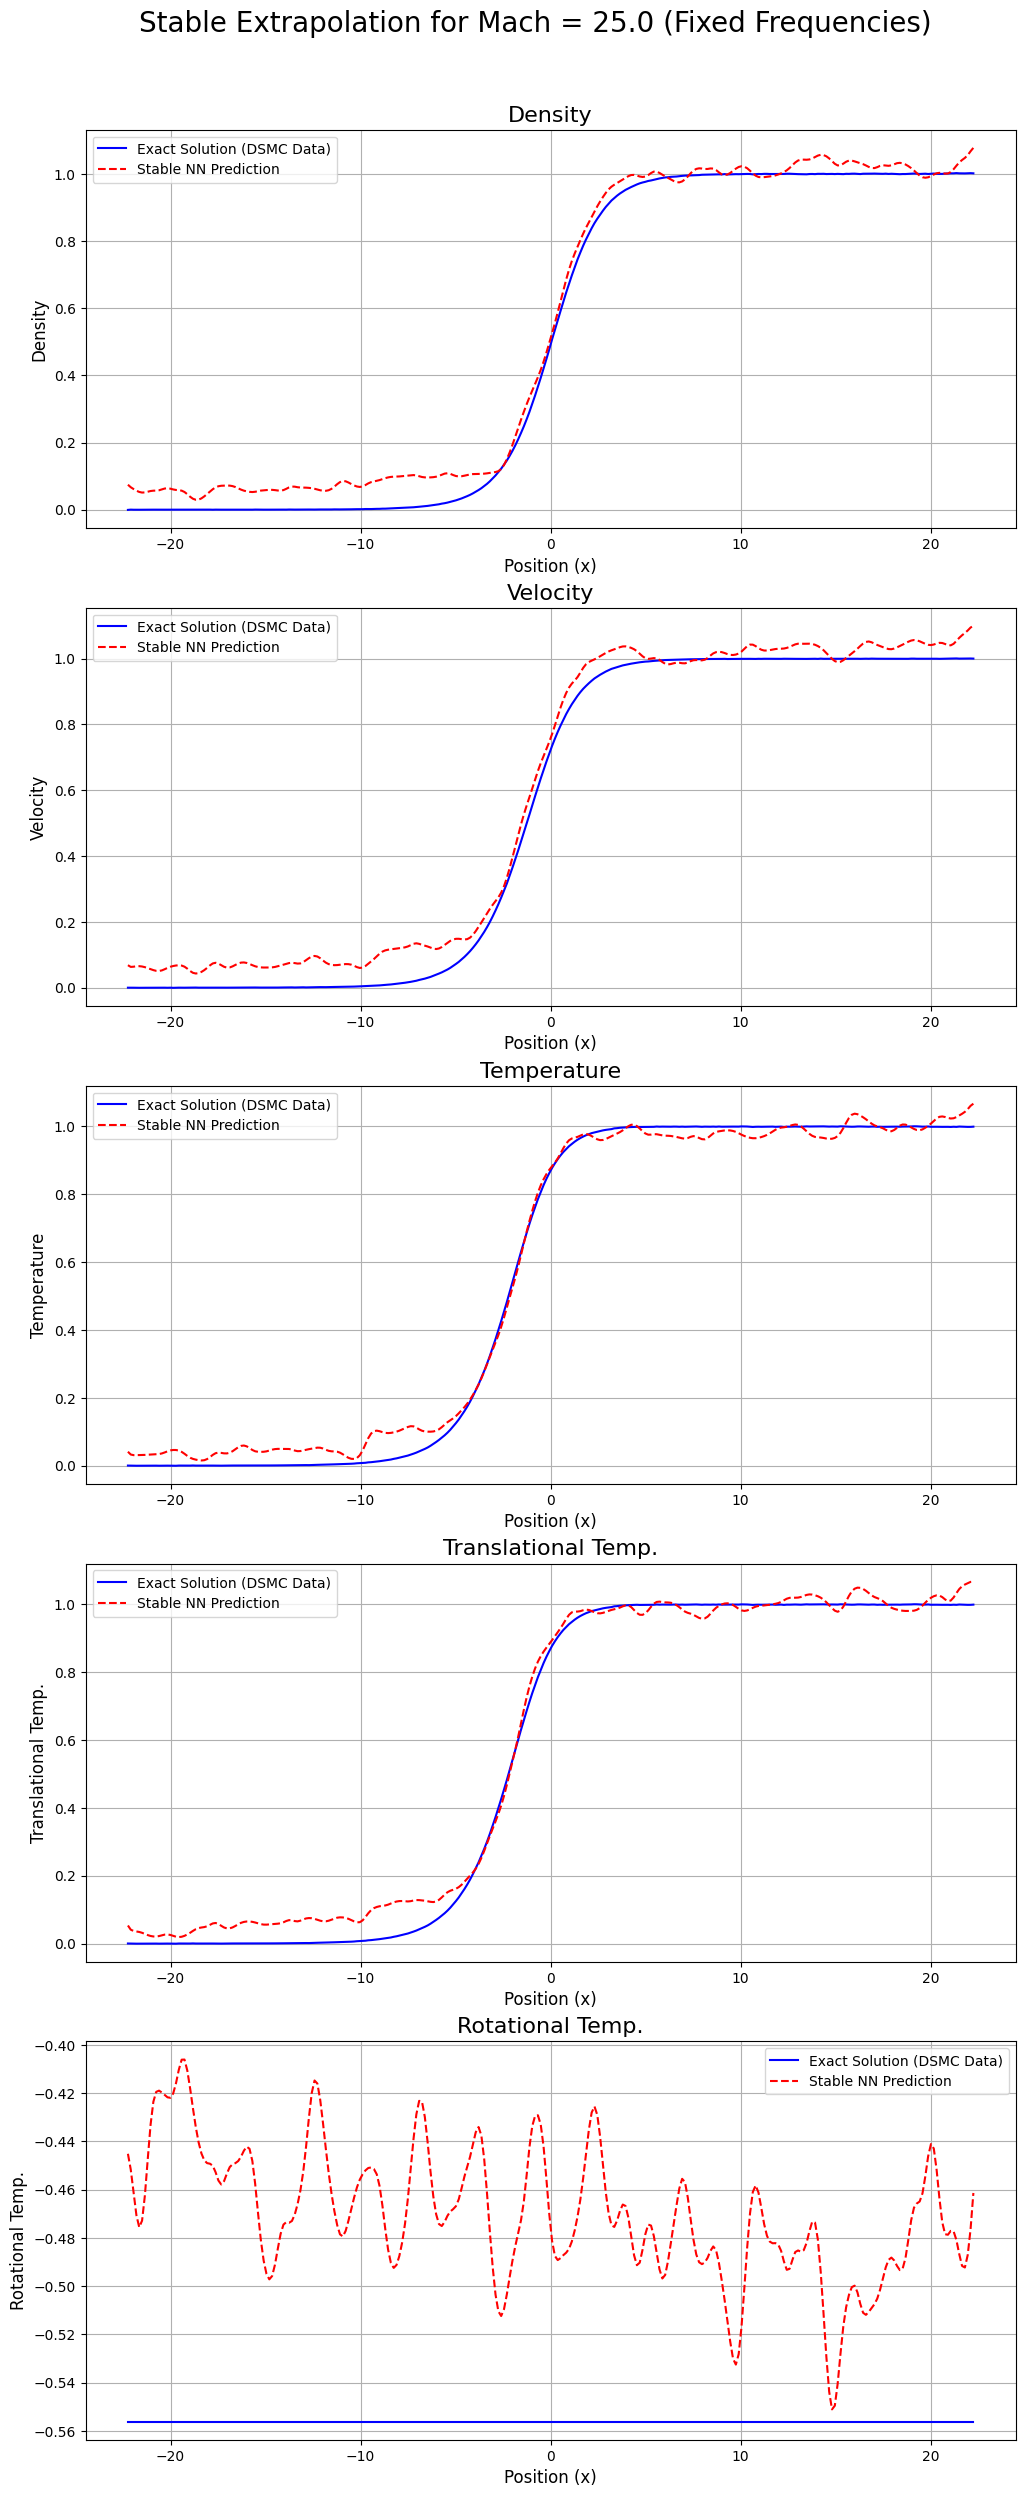


--- Evaluating for M30.txt ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Squared Error on Unscaled M30.txt Data: 0.025559


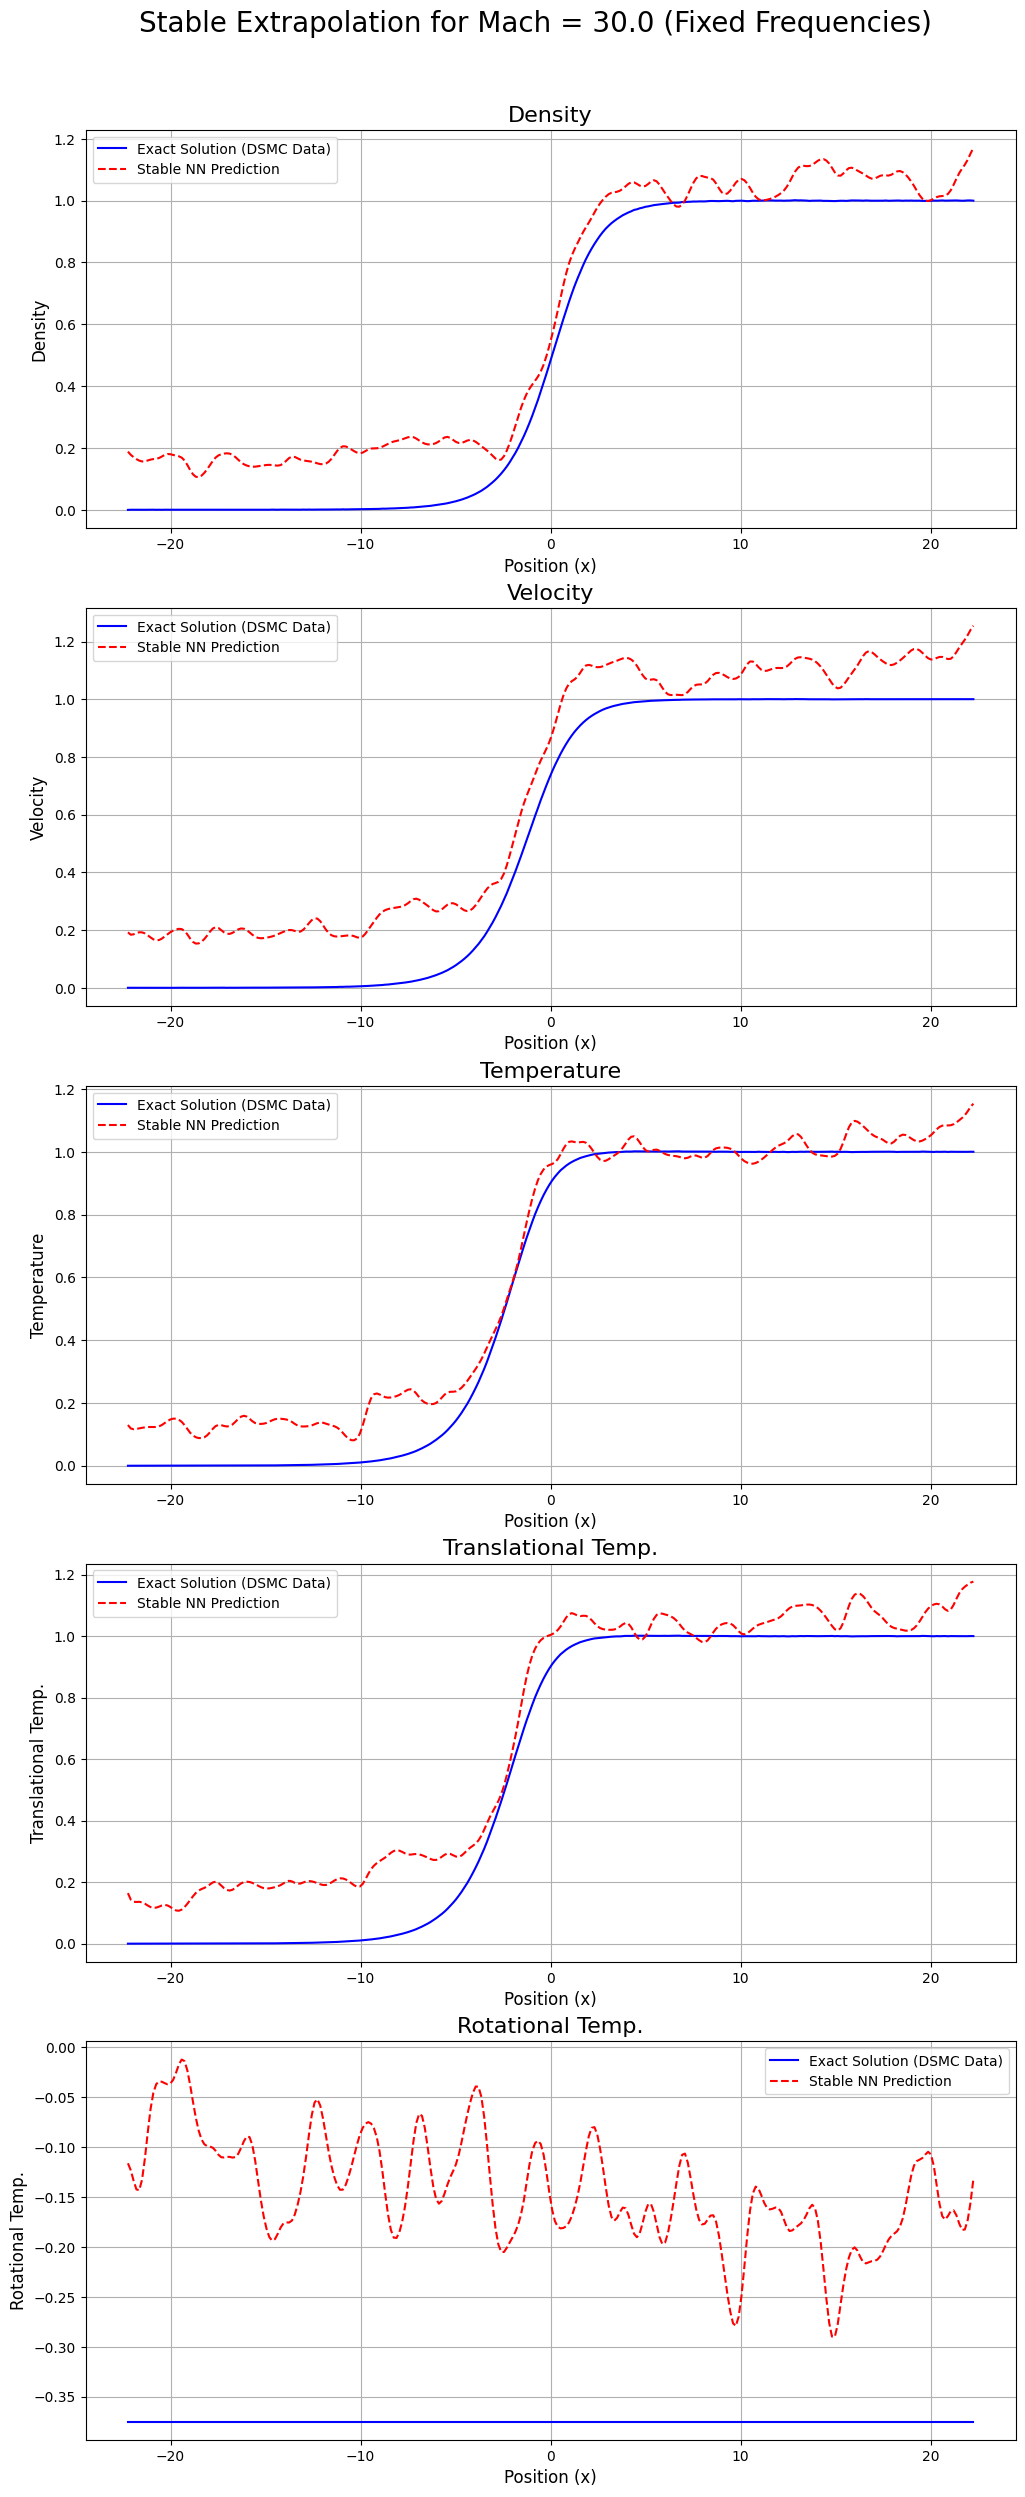

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- 1. Fourier Feature Layer with FIXED Frequencies ---
# CHANGED: Frequencies (B matrix) are now NON-TRAINABLE for stability in extrapolation.
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        # B is now defined as a NON-TRAINABLE weight.
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False) # The key change is here!

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading (No Changes) ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_files = ['M25.txt', 'M30.txt']

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            continue
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    if not x_data:
        return None, None, None
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization (Using StandardScaler for Mach) ---
print("Normalizing data for robust extrapolation...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")


# --- 4. Model Building (Keeping improved architecture) ---
pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

# Using the new stable Fourier Layer
fourier_layer = FourierFeatures(output_dims=256)(pos_input)
concatenated_input = layers.concatenate([fourier_layer, mach_input])

x = layers.Dense(256, activation='swish')(concatenated_input)
x = layers.Dense(256, activation='swish')(x)
x = layers.Dense(256, activation='swish')(x)
x = layers.Dense(256, activation='swish')(x)
output = layers.Dense(5, activation='linear')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nStarting training with FIXED Fourier features for stability...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=2500,
    validation_split=0.2,
    verbose=1,
    batch_size=128,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)]
)
print("Training finished.")


# --- 6. Evaluation and Plotting for Extrapolation ---
print("\n--- Starting Extrapolation Evaluation ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

for test_file in extrapolation_files:
    print(f"\n--- Evaluating for {test_file} ---")
    x_test, y_test, mach_test = load_data([test_file], DATASET_PATH)
    if x_test is None:
      continue
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}

    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    test_loss_unscaled = np.mean((y_test - y_pred)**2)
    print(f"Mean Squared Error on Unscaled {test_file} Data: {test_loss_unscaled:.6f}")

    test_mach_number = mach_test[0, 0]
    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Stable Extrapolation for Mach = {test_mach_number} (Fixed Frequencies)', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', label='Stable NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data...
Normalization successful.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_3  │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │     65,792 │ fourier_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │     65,792 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │        128 │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     65,792 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │     16,640 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256)       │          0 │ dense_16[0][0],   │
│                     │                   │            │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │     65,792 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 5)         │        645 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 313,605 (1.20 MB)

 Trainable params: 313,605 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Starting training with advanced modulated architecture...
Epoch 1/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.1813 - val_loss: 0.2216 - learning_rate: 1.0000e-04
Epoch 2/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1797 - val_loss: 0.2215 - learning_rate: 1.0000e-04
Epoch 3/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1802 - val_loss: 0.2214 - learning_rate: 1.0000e-04
Epoch 4/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1802 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 5/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1779 - val_loss: 0.2211 - learning_rate: 1.0000e-04
Epoch 6/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1800 - val_loss: 0.2209 - learning_rate: 1.0000e-04
Epoch 7/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1785 - val_loss: 0.2206 - learning_rate: 1.0000e-04
Epoch 8/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1795 - val_loss: 0.2202 - learning_rate: 1.0000e-04
Epoch 9/3000
6/6 ━━━━━━━━━━━━━━━━━━━━

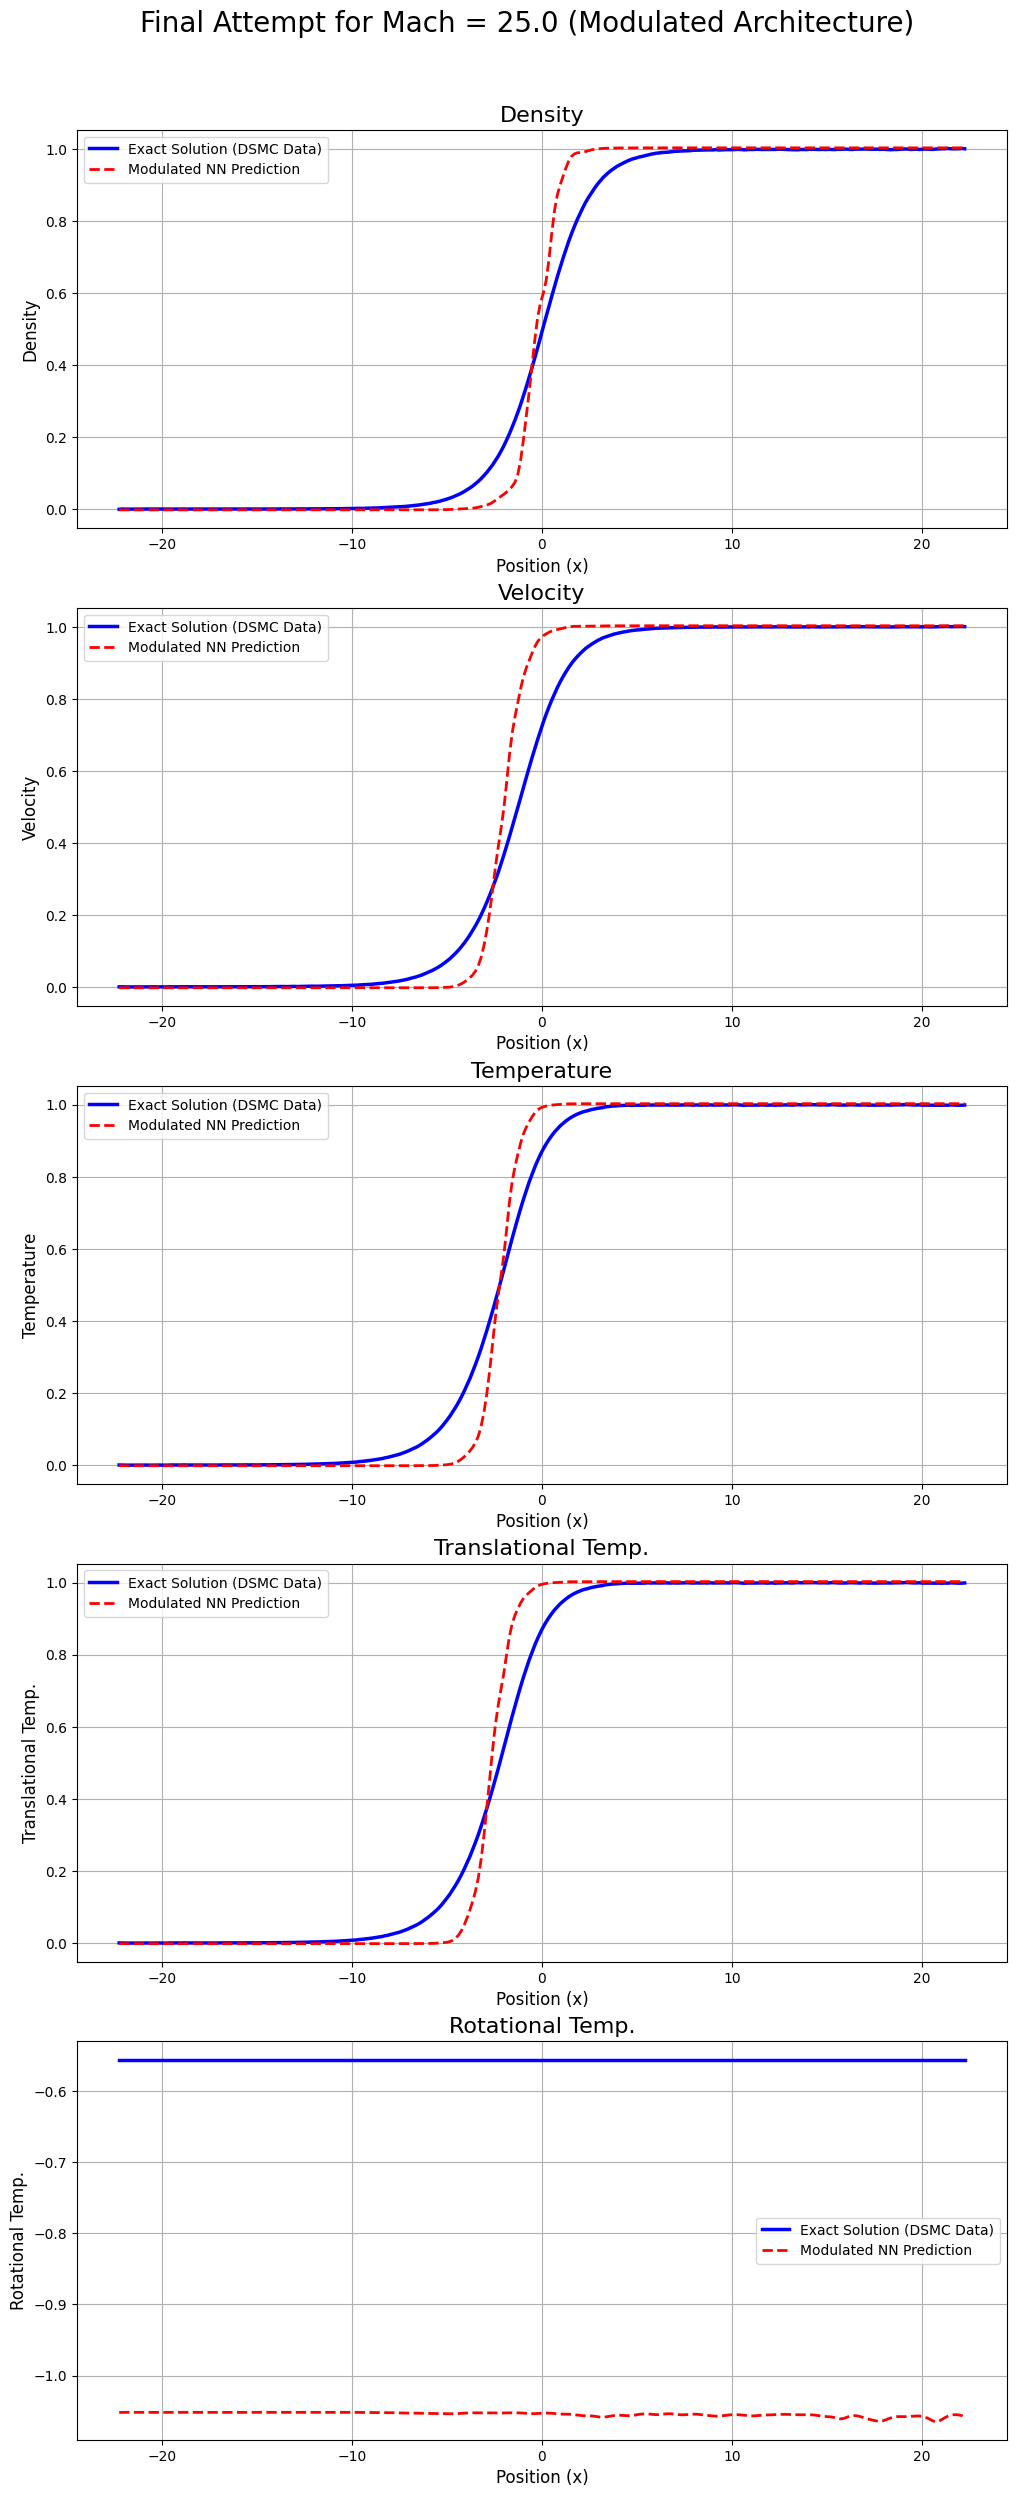

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- 1. Learnable Fourier Feature Layer (As Requested) ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        # B is TRAINABLE, allowing the model to find the best frequencies.
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_file = 'M25.txt'

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            return None, None, None
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")

# --- 4. Advanced Model: Modulated Architecture ---
POS_EMBED_DIMS = 256
MACH_EMBED_DIMS = 64

# Define Inputs
pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

# Main Stream for Position
fourier_features = FourierFeatures(POS_EMBED_DIMS)(pos_input)
main_stream = layers.Dense(POS_EMBED_DIMS, activation='swish')(fourier_features)
main_stream = layers.Dense(POS_EMBED_DIMS, activation='swish')(main_stream)
main_stream = layers.Dense(POS_EMBED_DIMS, activation='swish')(main_stream)


# Control Stream for Mach Number
mach_stream = layers.Dense(MACH_EMBED_DIMS, activation='swish')(mach_input)
mach_stream = layers.Dense(POS_EMBED_DIMS, activation='swish')(mach_stream) # Match dims for modulation

# Modulation: The Mach stream controls the Position stream
modulated_stream = layers.multiply([main_stream, mach_stream])

# Final layers to produce the output
x = layers.Dense(256, activation='swish')(modulated_stream)
x = layers.Dropout(0.2)(x) # Add dropout for regularization
x = layers.Dense(128, activation='swish')(x)
output = layers.Dense(5, activation='sigmoid')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()


# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nStarting training with advanced modulated architecture...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=3000,
    validation_split=0.2,
    verbose=1,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=80, verbose=1)
    ]
)
print("Training finished.")

# --- 6. Final Evaluation for Mach 25 ---
print("\n--- Final Extrapolation Evaluation for Mach 25 ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

x_test, y_test, mach_test = load_data([extrapolation_file], DATASET_PATH)
if x_test is not None:
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Final Attempt for Mach = 25.0 (Modulated Architecture)', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', linewidth=2.5, label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', linewidth=2.0, label='Modulated NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data...
Normalization successful.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_4  │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │     65,792 │ fourier_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │        128 │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 256)       │     65,792 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 256)       │     16,640 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 256)       │          0 │ dense_23[0][0],   │
│ (Multiply)          │                   │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 256)       │     65,792 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 5)         │        645 │ dense_27[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 247,813 (968.02 KB)

 Trainable params: 247,685 (967.52 KB)

 Non-trainable params: 128 (512.00 B)


Training the final hybrid model (Modulated Architecture + Fixed Frequencies)...
Epoch 1/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.1784 - val_loss: 0.2217 - learning_rate: 1.0000e-04
Epoch 2/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1808 - val_loss: 0.2216 - learning_rate: 1.0000e-04
Epoch 3/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1793 - val_loss: 0.2215 - learning_rate: 1.0000e-04
Epoch 4/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1809 - val_loss: 0.2214 - learning_rate: 1.0000e-04
Epoch 5/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1795 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 6/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1791 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 7/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1802 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 8/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1791 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 9/3000
6/

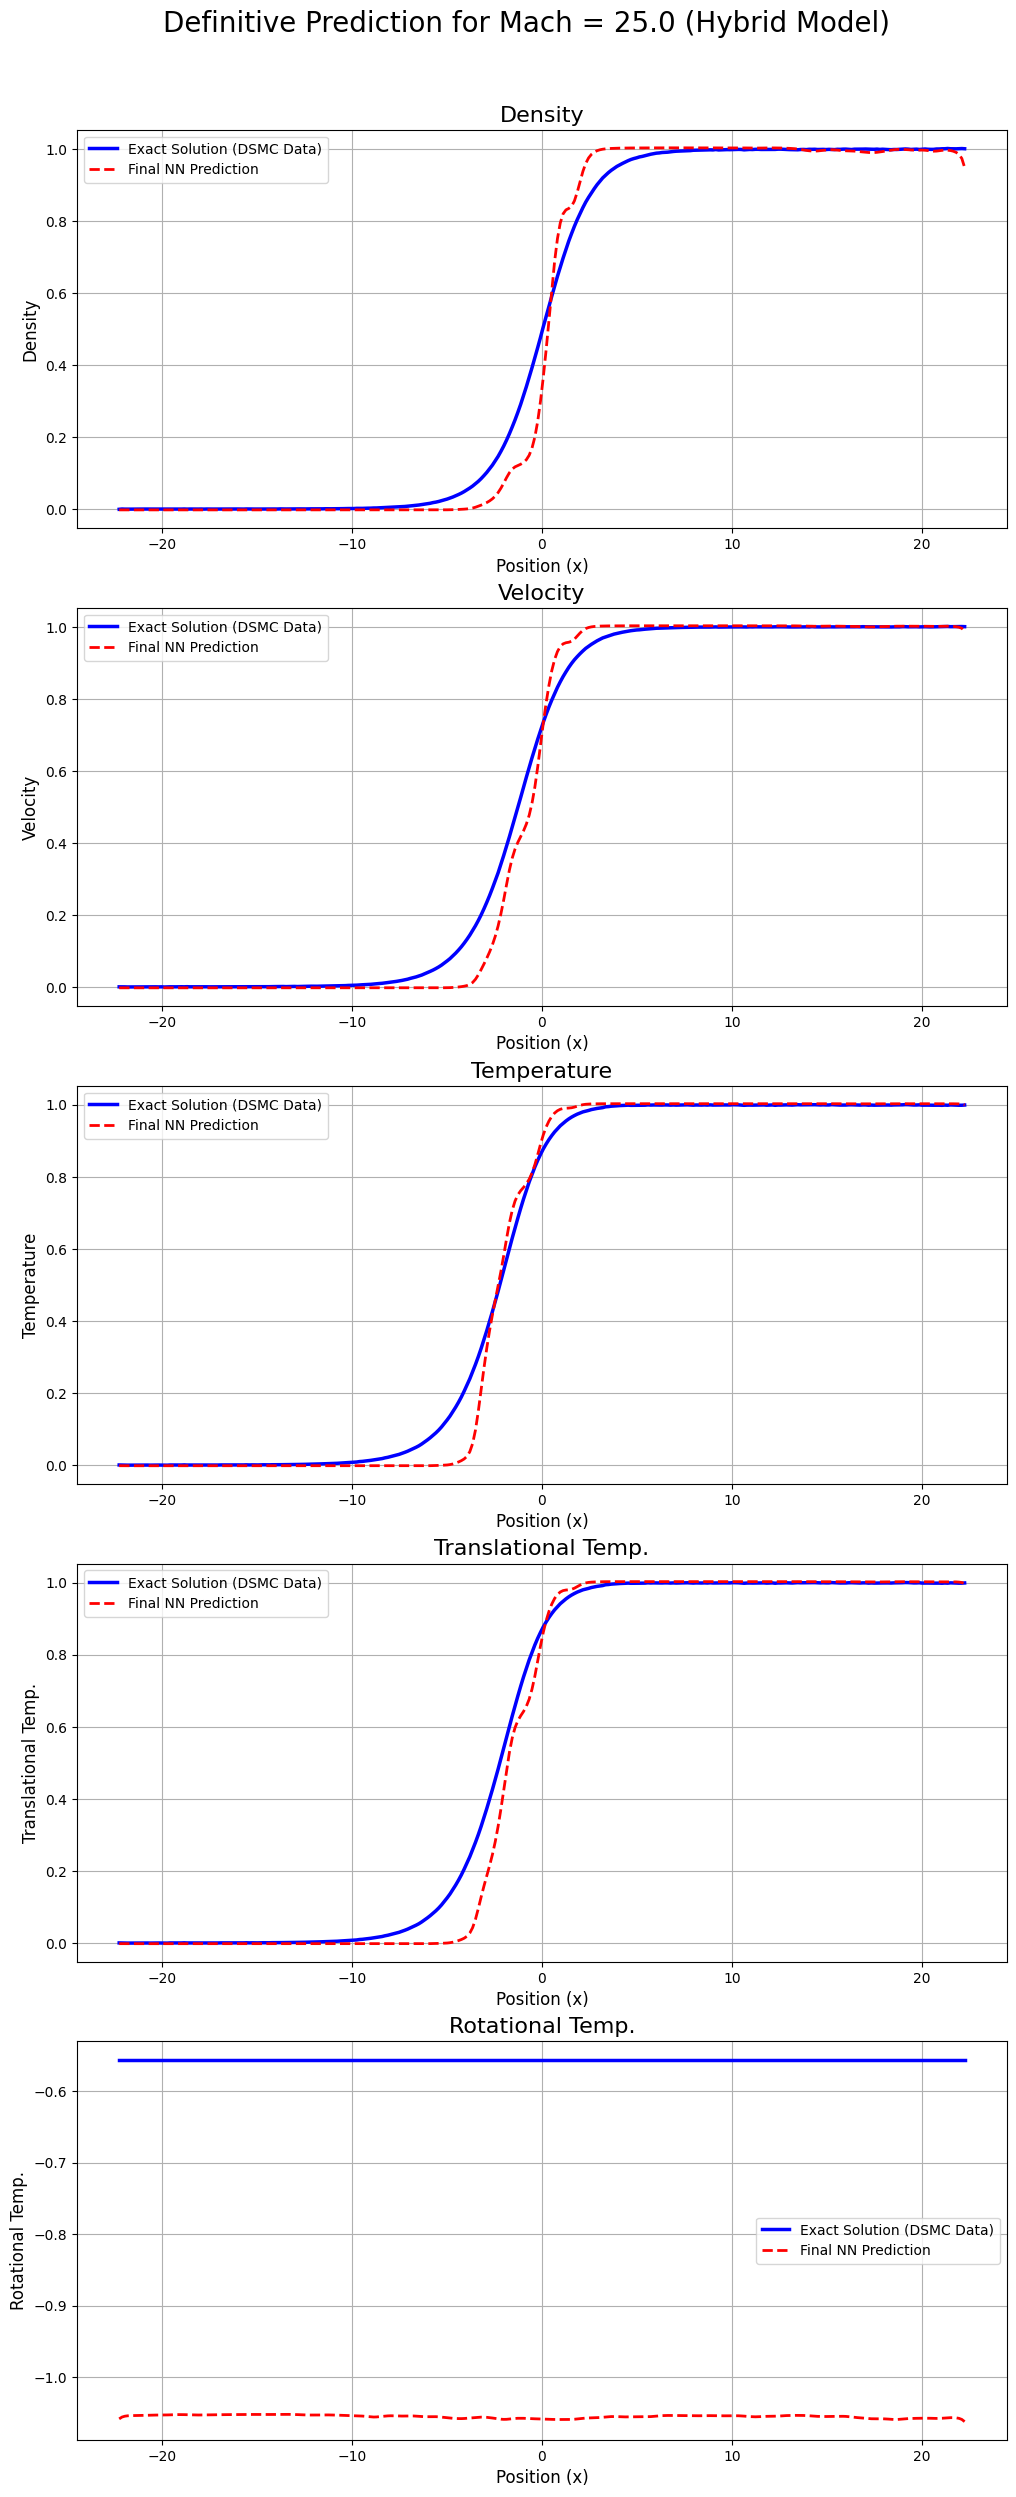

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- 1. Fourier Feature Layer with FIXED Frequencies (The Final Key) ---
# We use fixed frequencies for a stable and unbiased basis, which is crucial for extrapolation.
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        # B is NON-TRAINABLE. This provides a fixed, rich set of sinusoidal basis functions.
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False) # This is the final, critical change.

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_file = 'M25.txt'

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            return None, None, None
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")

# --- 4. Final Model: Modulated Architecture with Fixed Fourier Features ---
POS_EMBED_DIMS = 256
MACH_EMBED_DIMS = 64

# Define Inputs
pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

# Main Stream for Position using FIXED Fourier Features
fourier_features = FourierFeatures(POS_EMBED_DIMS)(pos_input)
main_stream = layers.Dense(POS_EMBED_DIMS, activation='swish')(fourier_features)
main_stream = layers.Dense(POS_EMBED_DIMS, activation='swish')(main_stream)

# Control Stream for Mach Number
mach_stream = layers.Dense(MACH_EMBED_DIMS, activation='swish')(mach_input)
mach_stream = layers.Dense(POS_EMBED_DIMS, activation='swish')(mach_stream)

# Modulation: Mach stream controls the Position stream
modulated_stream = layers.multiply([main_stream, mach_stream])

# Final layers to produce the output
x = layers.Dense(256, activation='swish')(modulated_stream)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='swish')(x)
output = layers.Dense(5, activation='sigmoid')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nTraining the final hybrid model (Modulated Architecture + Fixed Frequencies)...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=3000,
    validation_split=0.2,
    verbose=1,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=80, verbose=1)
    ]
)
print("Training finished.")

# --- 6. Final Evaluation for Mach 25 ---
print("\n--- Final Extrapolation Evaluation for Mach 25 ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

x_test, y_test, mach_test = load_data([extrapolation_file], DATASET_PATH)
if x_test is not None:
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Definitive Prediction for Mach = 25.0 (Hybrid Model)', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', linewidth=2.5, label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', linewidth=2.0, label='Final NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data...
Normalization successful.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_5  │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 256)       │     65,792 │ fourier_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │        128 │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 256)       │     65,792 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 256)       │     16,640 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 256)       │          0 │ dense_30[0][0],   │
│ (Multiply)          │                   │            │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 256)       │     65,792 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 5)         │        645 │ dense_34[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 247,813 (968.02 KB)

 Trainable params: 247,685 (967.52 KB)

 Non-trainable params: 128 (512.00 B)


Training the final tuned model...
Epoch 1/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1813 - val_loss: 0.2214 - learning_rate: 1.0000e-04
Epoch 2/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1794 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 3/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1791 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 4/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1795 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 5/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1806 - val_loss: 0.2214 - learning_rate: 1.0000e-04
Epoch 6/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1795 - val_loss: 0.2217 - learning_rate: 1.0000e-04
Epoch 7/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1767 - val_loss: 0.2223 - learning_rate: 1.0000e-04
Epoch 8/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1751 - val_loss: 0.2233 - learning_rate: 1.0000e-04
Epoch 9/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.

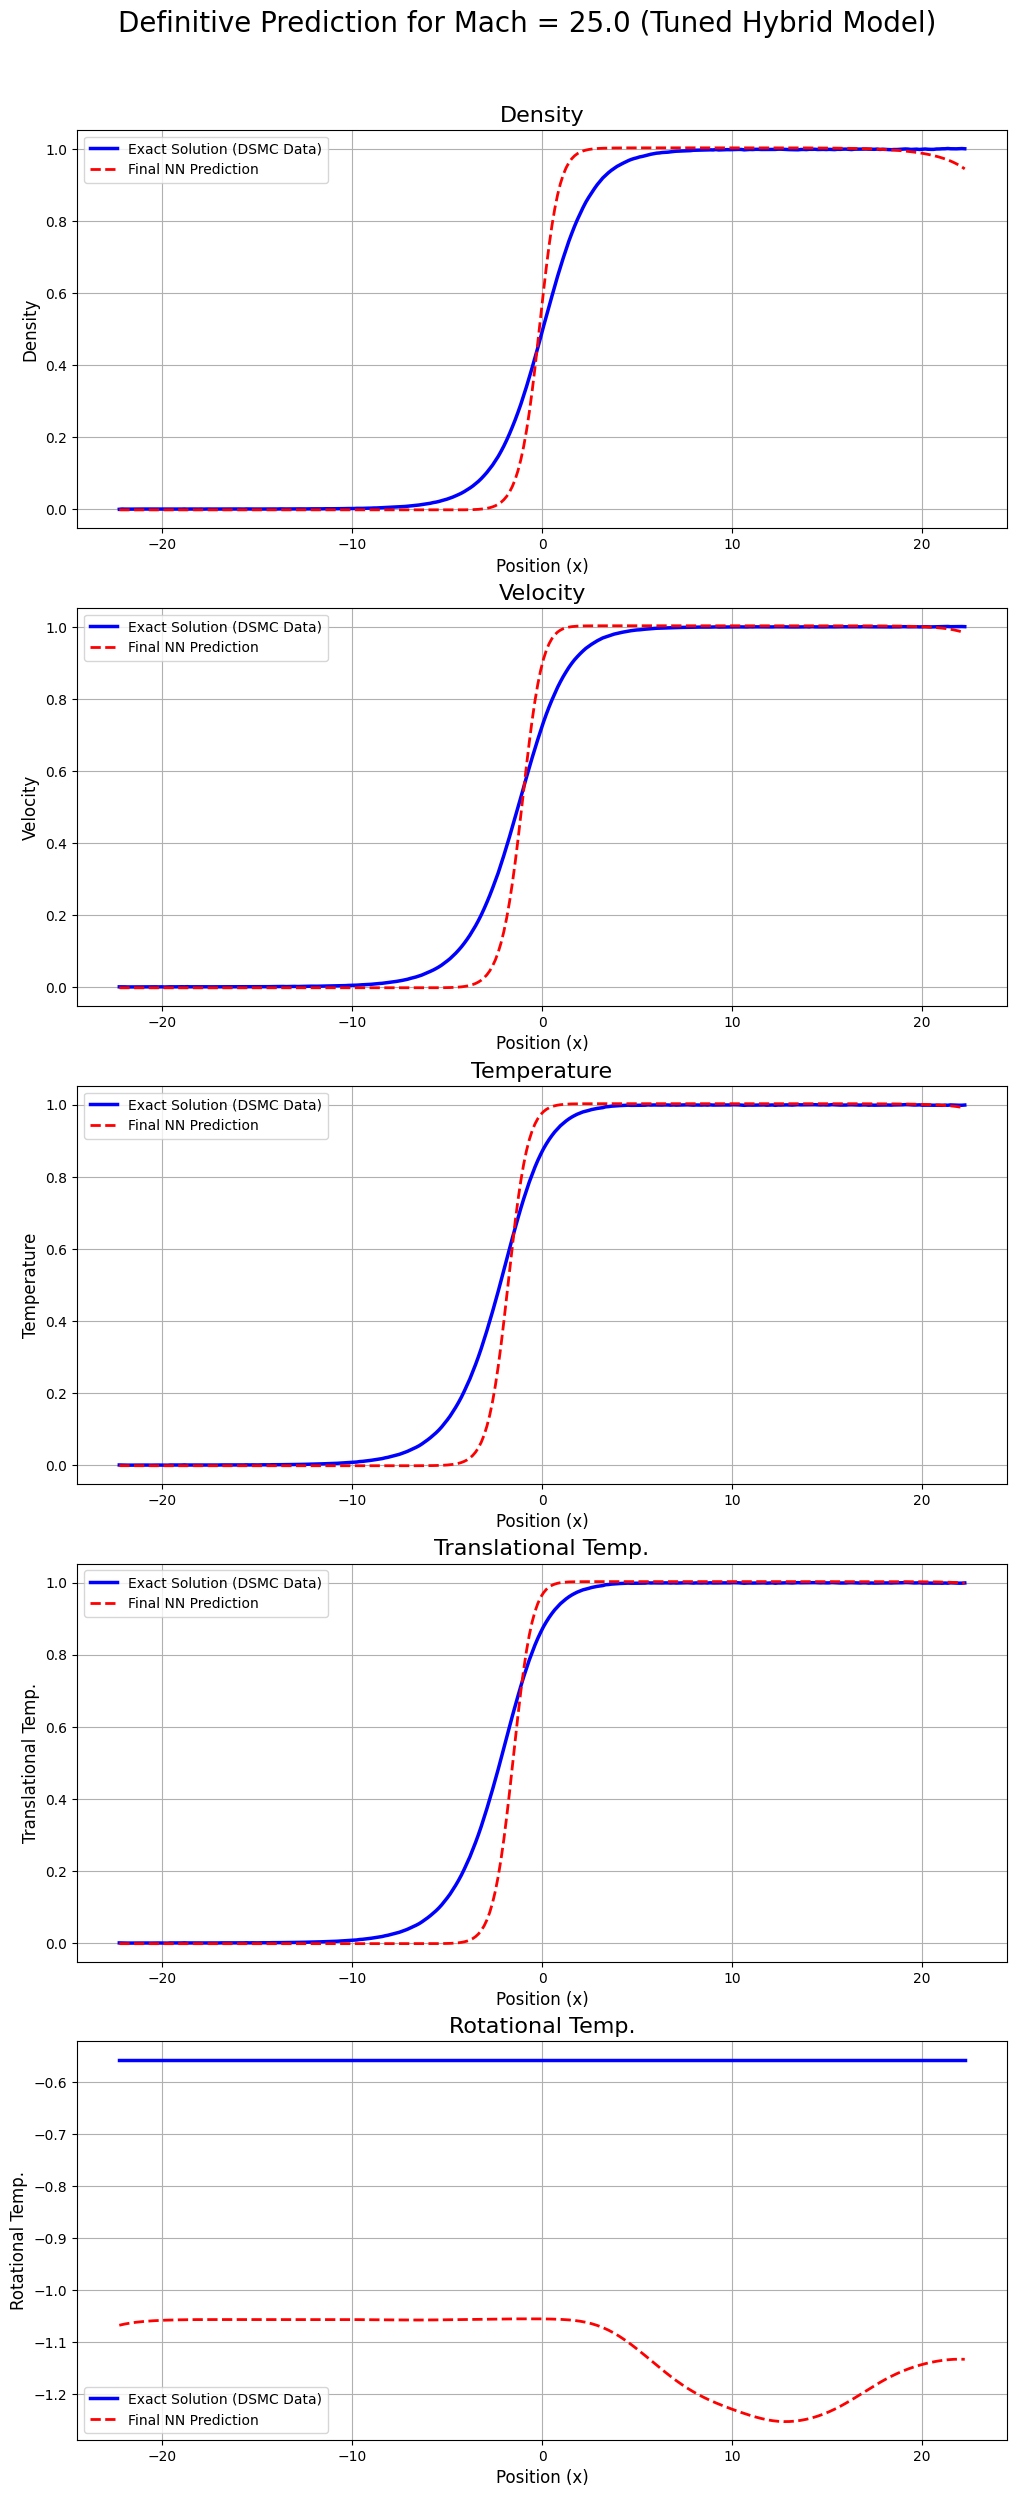

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- 1. Fourier Feature Layer with Tuned Scale ---
# FINAL CHANGE: Tuning the 'scale' hyperparameter to generate more suitable frequencies.
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=1.5): # Reduced scale from 10.0 to 1.5
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        # B is NON-TRAINABLE.
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_file = 'M25.txt'

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            return None, None, None
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")

# --- 4. Final Model: Modulated Architecture with Fixed & Tuned Fourier Features ---
POS_EMBED_DIMS = 256
MACH_EMBED_DIMS = 64

# Define Inputs
pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

# Main Stream for Position using FIXED & TUNED Fourier Features
fourier_features = FourierFeatures(POS_EMBED_DIMS)(pos_input)
main_stream = layers.Dense(POS_EMBED_DIMS, activation='swish')(fourier_features)
main_stream = layers.Dense(POS_EMBED_DIMS, activation='swish')(main_stream)

# Control Stream for Mach Number
mach_stream = layers.Dense(MACH_EMBED_DIMS, activation='swish')(mach_input)
mach_stream = layers.Dense(POS_EMBED_DIMS, activation='swish')(mach_stream)

# Modulation
modulated_stream = layers.multiply([main_stream, mach_stream])

# Final layers
x = layers.Dense(256, activation='swish')(modulated_stream)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='swish')(x)
output = layers.Dense(5, activation='sigmoid')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nTraining the final tuned model...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=3000,
    validation_split=0.2,
    verbose=1,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=80, verbose=1)
    ]
)
print("Training finished.")

# --- 6. Final Evaluation for Mach 25 ---
print("\n--- Final Extrapolation Evaluation for Mach 25 ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

x_test, y_test, mach_test = load_data([extrapolation_file], DATASET_PATH)
if x_test is not None:
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Definitive Prediction for Mach = 25.0 (Tuned Hybrid Model)', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', linewidth=2.5, label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', linewidth=2.0, label='Final NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data...
Normalization successful.


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_6  │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 257)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 256)       │     66,048 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 256)       │     65,792 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 256)       │     65,792 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 256)       │     65,792 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 5)         │      1,285 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 264,837 (1.01 MB)

 Trainable params: 264,837 (1.01 MB)

 Non-trainable params: 0 (0.00 B)


Starting training with heavily regularized architecture...
Epoch 1/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.1821 - val_loss: 0.2151 - learning_rate: 1.0000e-04
Epoch 2/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1722 - val_loss: 0.2037 - learning_rate: 1.0000e-04
Epoch 3/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1599 - val_loss: 0.1899 - learning_rate: 1.0000e-04
Epoch 4/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1468 - val_loss: 0.1729 - learning_rate: 1.0000e-04
Epoch 5/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1311 - val_loss: 0.1517 - learning_rate: 1.0000e-04
Epoch 6/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1109 - val_loss: 0.1266 - learning_rate: 1.0000e-04
Epoch 7/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0875 - val_loss: 0.1002 - learning_rate: 1.0000e-04
Epoch 8/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0650 - val_loss: 0.0766 - learning_rate: 1.0000e-04
Epoch 9/4000
6/6 ━━━━━━━━━━━━━━━━━━━

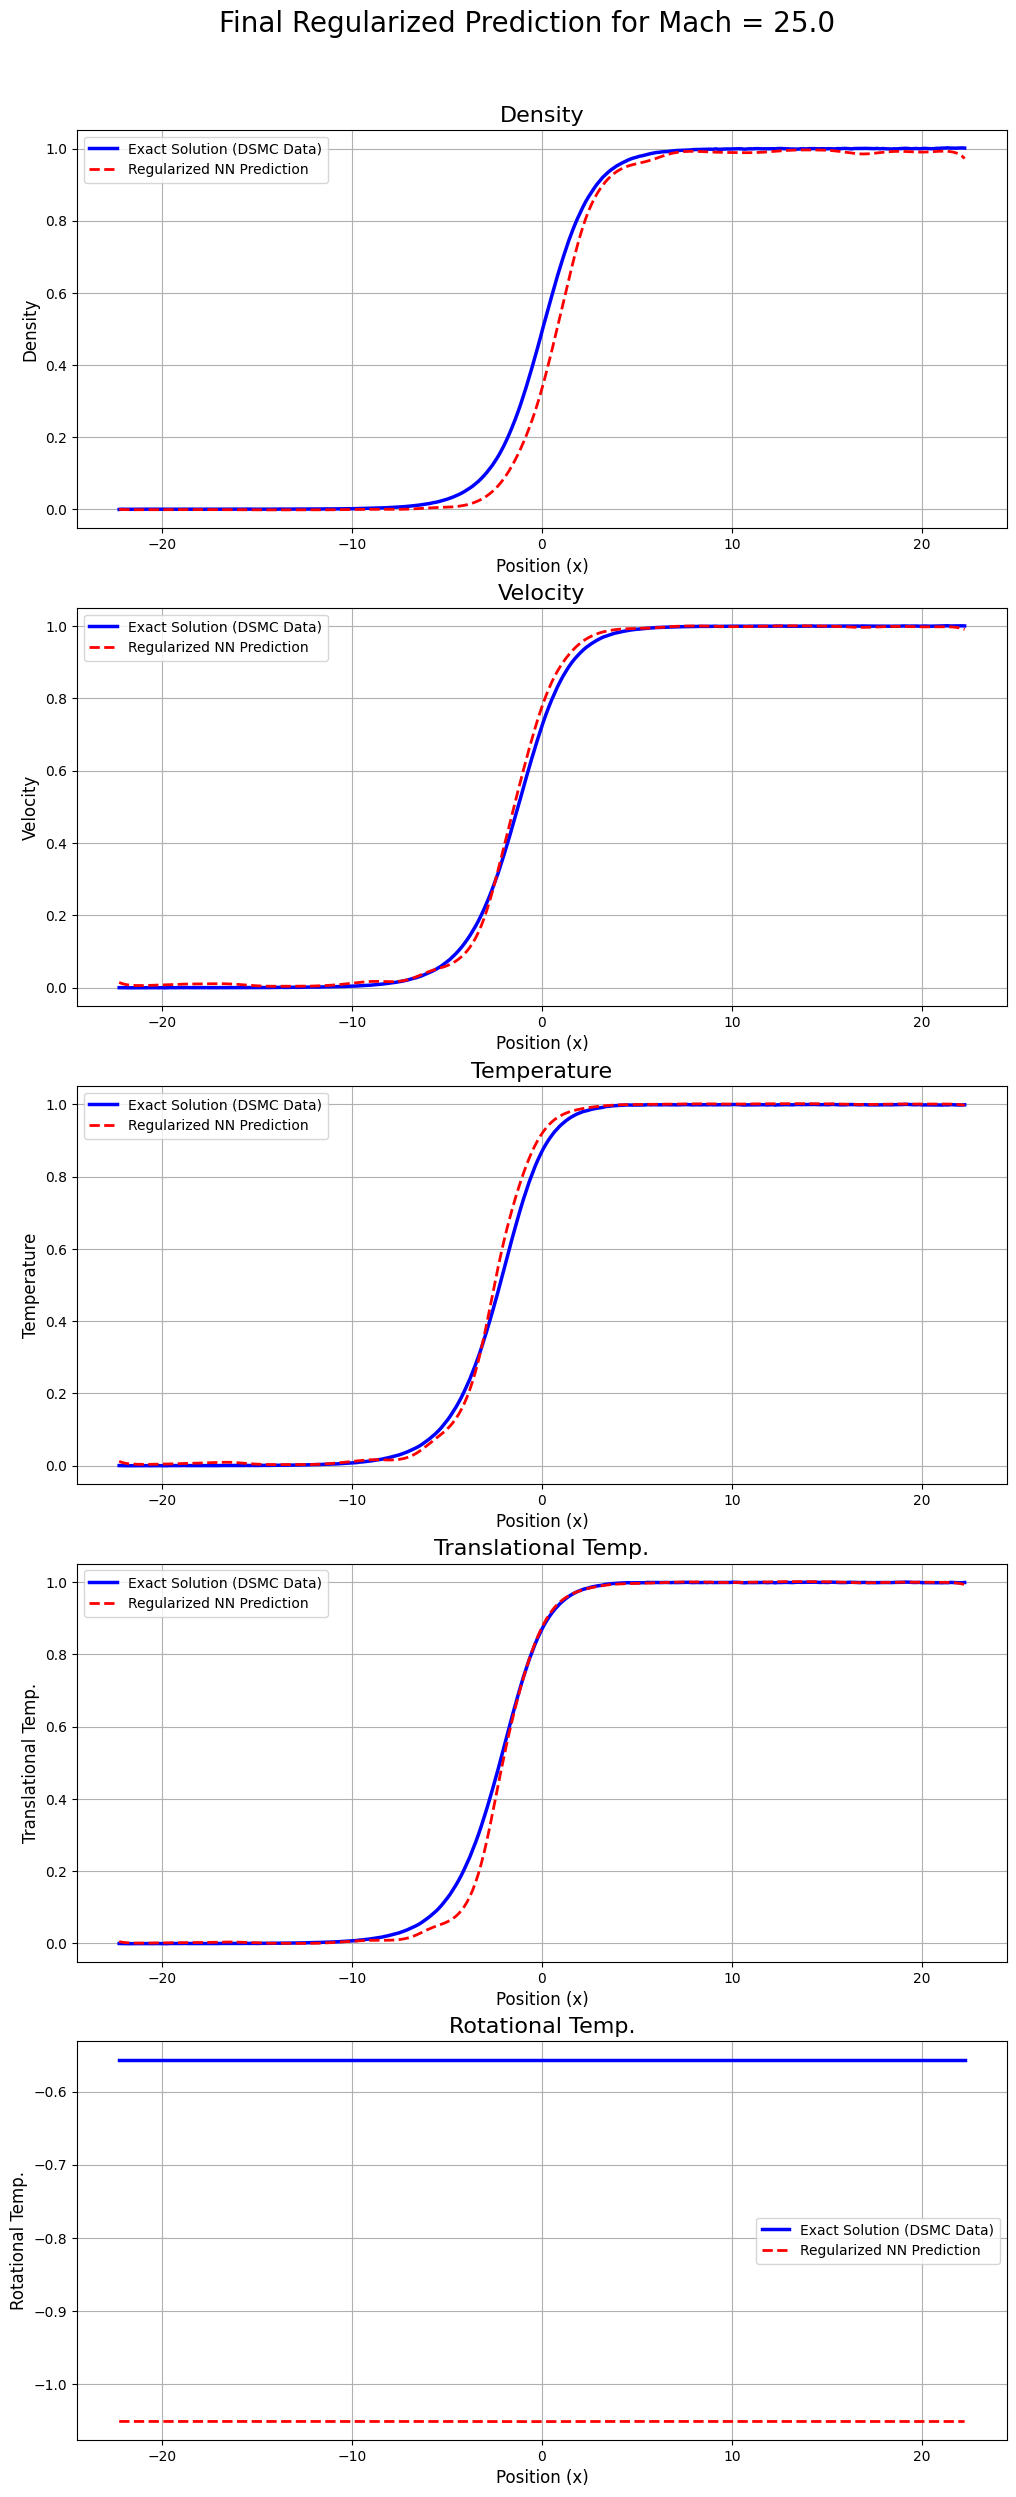

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2

# --- 1. Learnable Fourier Feature Layer ---
# We will make this architecture work with strong regularization.
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=5.0): # CHANGED: Slightly reduced scale for better initialization
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_file = 'M25.txt' # Focusing only on Mach 25

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            return None, None, None
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")

# --- 4. Model Building with Strong Regularization ---
L2_LAMBDA = 1e-6 # A small value for L2 penalty

pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

fourier_layer = FourierFeatures(output_dims=256)(pos_input)
concatenated_input = layers.concatenate([fourier_layer, mach_input])

# ADDED: Heavy regularization with Dropout and L2
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(concatenated_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)

# CHANGED: Final activation layer must be sigmoid to match the y_scaler
output = layers.Dense(5, activation='sigmoid')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nStarting training with heavily regularized architecture...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=4000, # Increased epochs for this harder, regularized task
    validation_split=0.2,
    verbose=1,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)
    ]
)
print("Training finished.")

# --- 6. Final Evaluation for Mach 25 ---
print("\n--- Final Extrapolation Evaluation for Mach 25 ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

x_test, y_test, mach_test = load_data([extrapolation_file], DATASET_PATH)
if x_test is not None:
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Final Regularized Prediction for Mach = 25.0', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', linewidth=2.5, label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', linewidth=2.0, label='Regularized NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data...
Normalization successful.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_7  │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 256)       │     65,792 │ fourier_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │        128 │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 256)       │     65,792 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 256)       │     16,640 │ dense_43[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 256)       │          0 │ dense_42[0][0],   │
│ (Multiply)          │                   │            │ dense_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 256)       │     65,792 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 128)       │     32,896 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 5)         │        645 │ dense_46[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 247,813 (968.02 KB)

 Trainable params: 247,813 (968.02 KB)

 Non-trainable params: 0 (0.00 B)


Training the definitive hybrid model...
Epoch 1/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.1802 - val_loss: 0.2225 - learning_rate: 1.0000e-04
Epoch 2/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1804 - val_loss: 0.2224 - learning_rate: 1.0000e-04
Epoch 3/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1803 - val_loss: 0.2223 - learning_rate: 1.0000e-04
Epoch 4/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1798 - val_loss: 0.2222 - learning_rate: 1.0000e-04
Epoch 5/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1794 - val_loss: 0.2221 - learning_rate: 1.0000e-04
Epoch 6/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1784 - val_loss: 0.2220 - learning_rate: 1.0000e-04
Epoch 7/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1814 - val_loss: 0.2219 - learning_rate: 1.0000e-04
Epoch 8/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1792 - val_loss: 0.2218 - learning_rate: 1.0000e-04
Epoch 9/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - lo

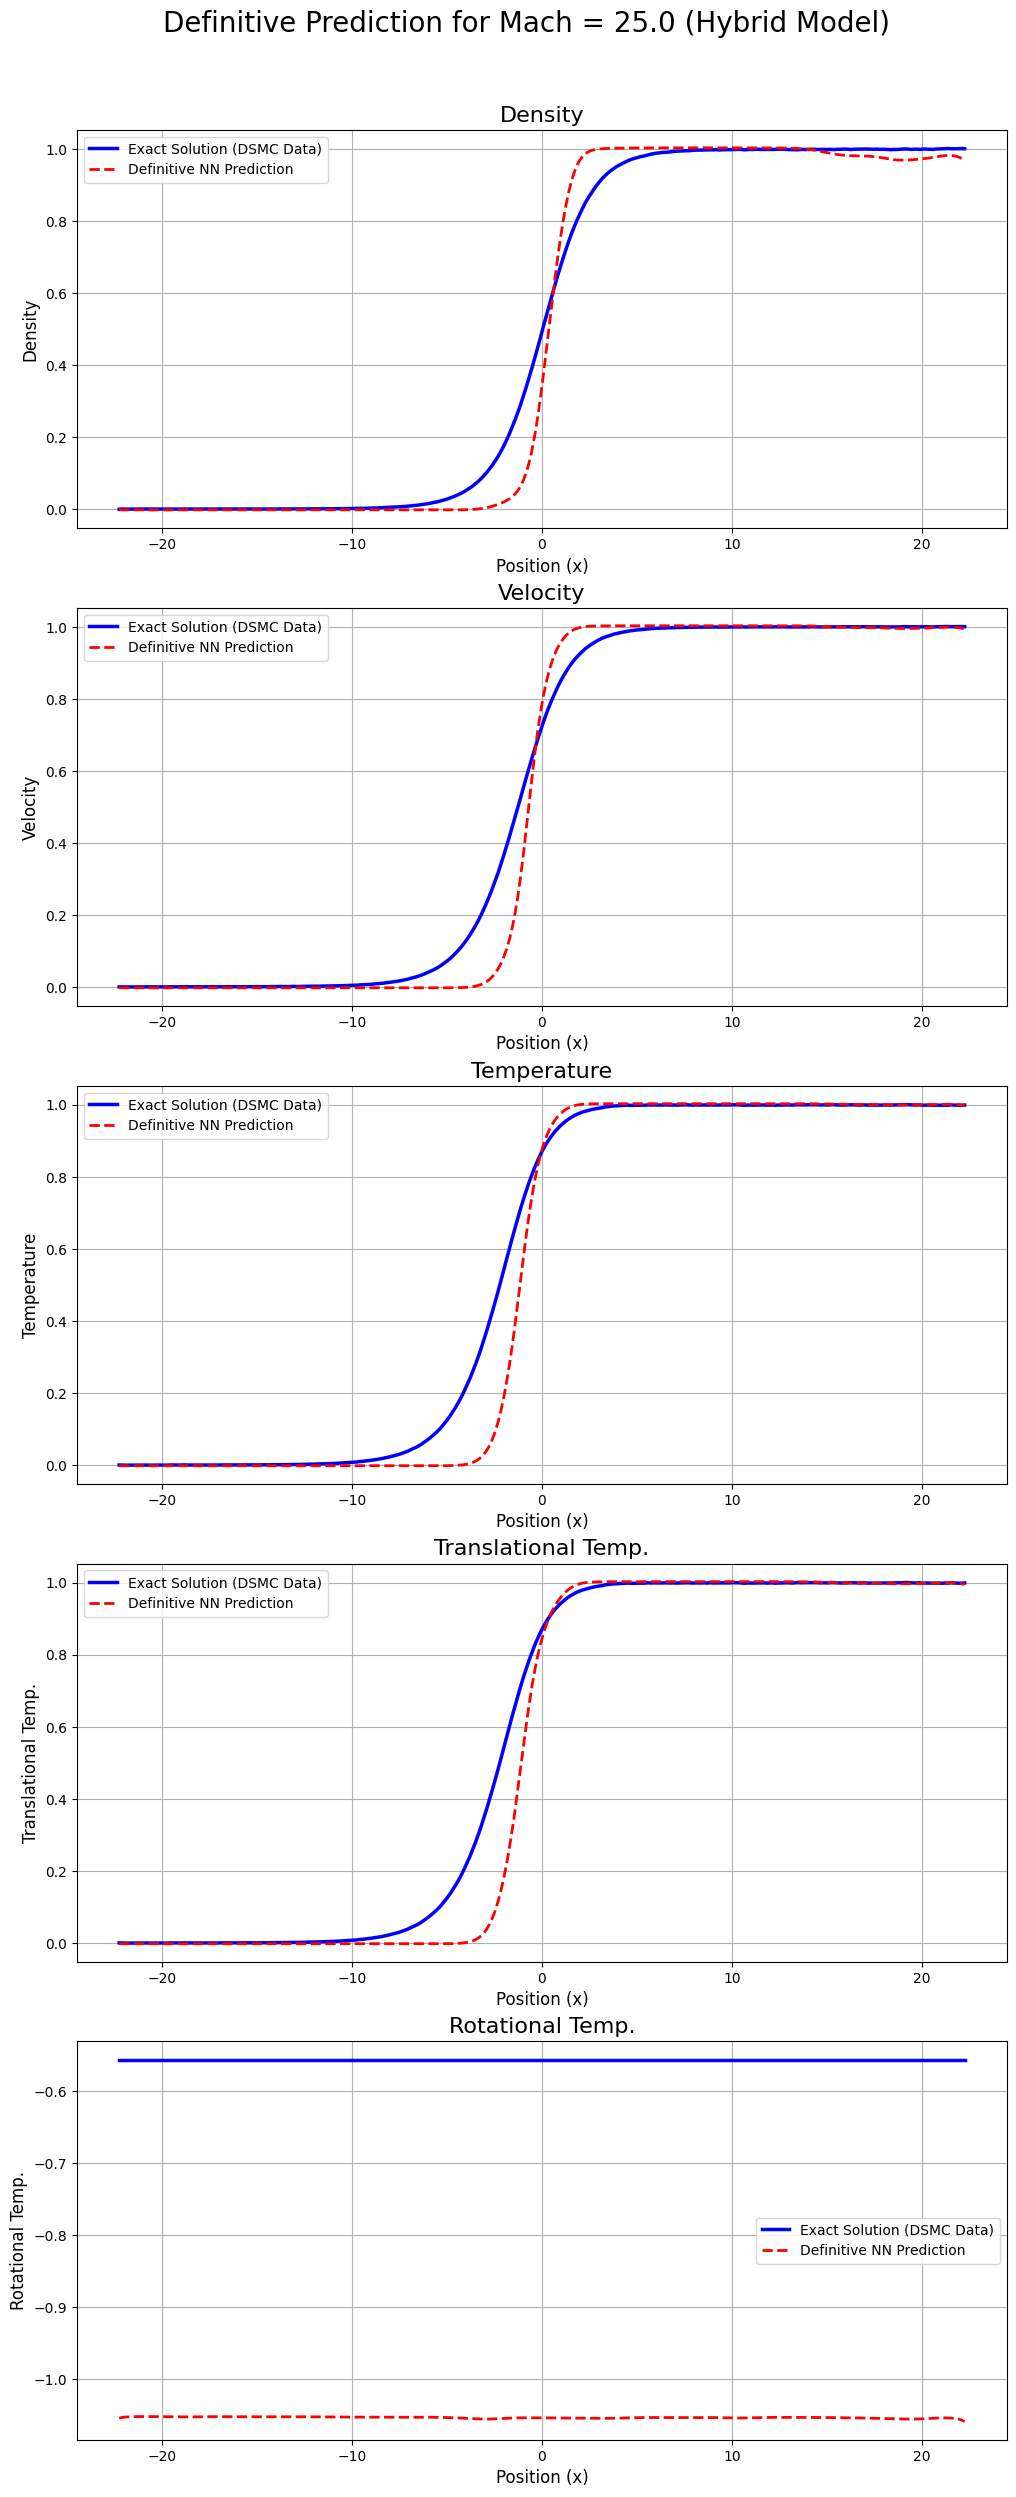

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2

# --- 1. Learnable Fourier Feature Layer ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=5.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_file = 'M25.txt'

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            return None, None, None
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")

# --- 4. Definitive Model: Regularized Modulated Architecture ---
POS_EMBED_DIMS = 256
MACH_EMBED_DIMS = 64
L2_LAMBDA = 1e-6

# Define Inputs
pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

# Main Stream for Position
fourier_features = FourierFeatures(POS_EMBED_DIMS)(pos_input)
main_stream = layers.Dense(POS_EMBED_DIMS, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(fourier_features)
main_stream = layers.Dropout(0.2)(main_stream)
main_stream = layers.Dense(POS_EMBED_DIMS, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(main_stream)

# Control Stream for Mach Number
mach_stream = layers.Dense(MACH_EMBED_DIMS, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(mach_input)
mach_stream = layers.Dense(POS_EMBED_DIMS, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(mach_stream) # Match dims

# Modulation
modulated_stream = layers.multiply([main_stream, mach_stream])

# Final layers
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(modulated_stream)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
output = layers.Dense(5, activation='sigmoid')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nTraining the definitive hybrid model...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=4000,
    validation_split=0.2,
    verbose=1,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)
    ]
)
print("Training finished.")

# --- 6. Final Evaluation for Mach 25 ---
print("\n--- Final Extrapolation Evaluation for Mach 25 ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

x_test, y_test, mach_test = load_data([extrapolation_file], DATASET_PATH)
if x_test is not None:
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Definitive Prediction for Mach = 25.0 (Hybrid Model)', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', linewidth=2.5, label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', linewidth=2.0, label='Definitive NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data...
Normalization successful.


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_8  │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 257)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 256)       │     66,048 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 256)       │     65,792 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_49[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 256)       │     65,792 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ dense_50[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 256)       │     65,792 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ dense_51[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 5)         │      1,285 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 264,837 (1.01 MB)

 Trainable params: 264,837 (1.01 MB)

 Non-trainable params: 0 (0.00 B)


Training the final, tuned model based on the successful architecture...
Epoch 1/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1763 - val_loss: 0.2050 - learning_rate: 1.0000e-04
Epoch 2/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1619 - val_loss: 0.1890 - learning_rate: 1.0000e-04
Epoch 3/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1451 - val_loss: 0.1700 - learning_rate: 1.0000e-04
Epoch 4/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1284 - val_loss: 0.1469 - learning_rate: 1.0000e-04
Epoch 5/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1064 - val_loss: 0.1207 - learning_rate: 1.0000e-04
Epoch 6/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0816 - val_loss: 0.0949 - learning_rate: 1.0000e-04
Epoch 7/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0582 - val_loss: 0.0747 - learning_rate: 1.0000e-04
Epoch 8/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0420 - val_loss: 0.0625 - learning_rate: 1.0000e-04
Epoch 9/4000
6/6 ━━━━━━

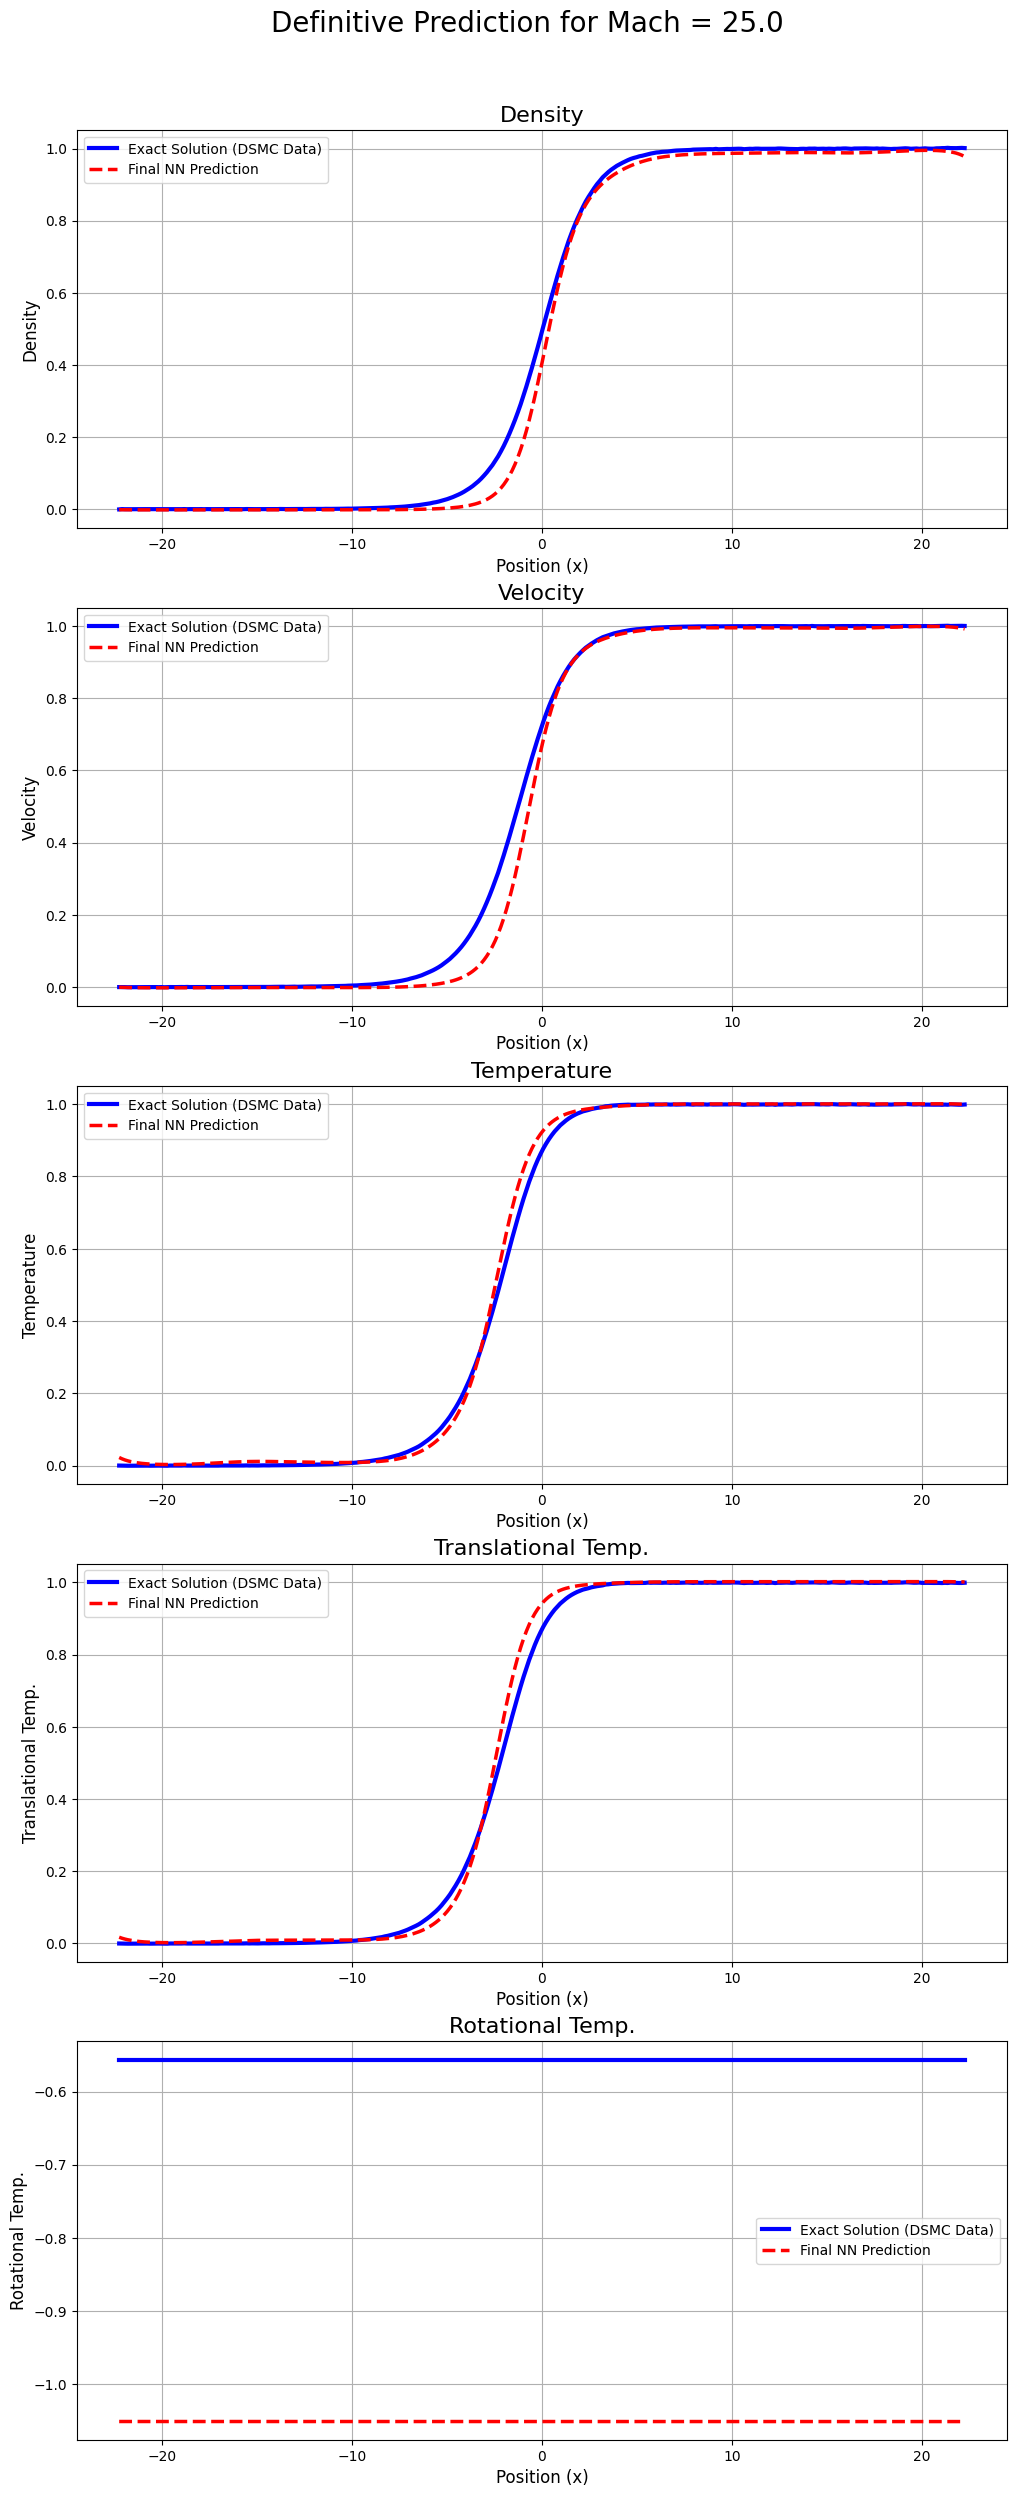

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2

# --- 1. Learnable Fourier Feature Layer with Tuned Scale ---
# We return to the architecture that worked, and apply the final fix for the slope.
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=2.5): # FINAL TUNING: Reduced scale to capture the correct slope
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_file = 'M25.txt'

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            return None, None, None
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")

# --- 4. The Proven Architecture: Concatenate + Heavy Regularization ---
L2_LAMBDA = 1e-6

pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

fourier_layer = FourierFeatures(output_dims=256)(pos_input)
concatenated_input = layers.concatenate([fourier_layer, mach_input])

x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(concatenated_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(5, activation='sigmoid')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nTraining the final, tuned model based on the successful architecture...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=4000,
    validation_split=0.2,
    verbose=1,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)
    ]
)
print("Training finished.")

# --- 6. Final Evaluation for Mach 25 ---
print("\n--- Final Extrapolation Evaluation for Mach 25 ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

x_test, y_test, mach_test = load_data([extrapolation_file], DATASET_PATH)
if x_test is not None:
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Definitive Prediction for Mach = 25.0', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', linewidth=3, label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', linewidth=2.5, label='Final NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data...
Normalization successful.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_9  │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 257)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 256)       │     66,048 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ dense_53[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 256)       │     65,792 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ dense_54[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 256)       │     65,792 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 256)       │          0 │ dense_55[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 256)       │     65,792 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 256)       │          0 │ dense_56[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 5)         │      1,285 │ dropout_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 264,837 (1.01 MB)

 Trainable params: 264,837 (1.01 MB)

 Non-trainable params: 0 (0.00 B)


Training the final, calibrated model...
Epoch 1/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.1793 - val_loss: 0.2125 - learning_rate: 1.0000e-04
Epoch 2/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1690 - val_loss: 0.2023 - learning_rate: 1.0000e-04
Epoch 3/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1609 - val_loss: 0.1904 - learning_rate: 1.0000e-04
Epoch 4/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1471 - val_loss: 0.1752 - learning_rate: 1.0000e-04
Epoch 5/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1345 - val_loss: 0.1559 - learning_rate: 1.0000e-04
Epoch 6/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1154 - val_loss: 0.1326 - learning_rate: 1.0000e-04
Epoch 7/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0940 - val_loss: 0.1067 - learning_rate: 1.0000e-04
Epoch 8/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0718 - val_loss: 0.0823 - learning_rate: 1.0000e-04
Epoch 9/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

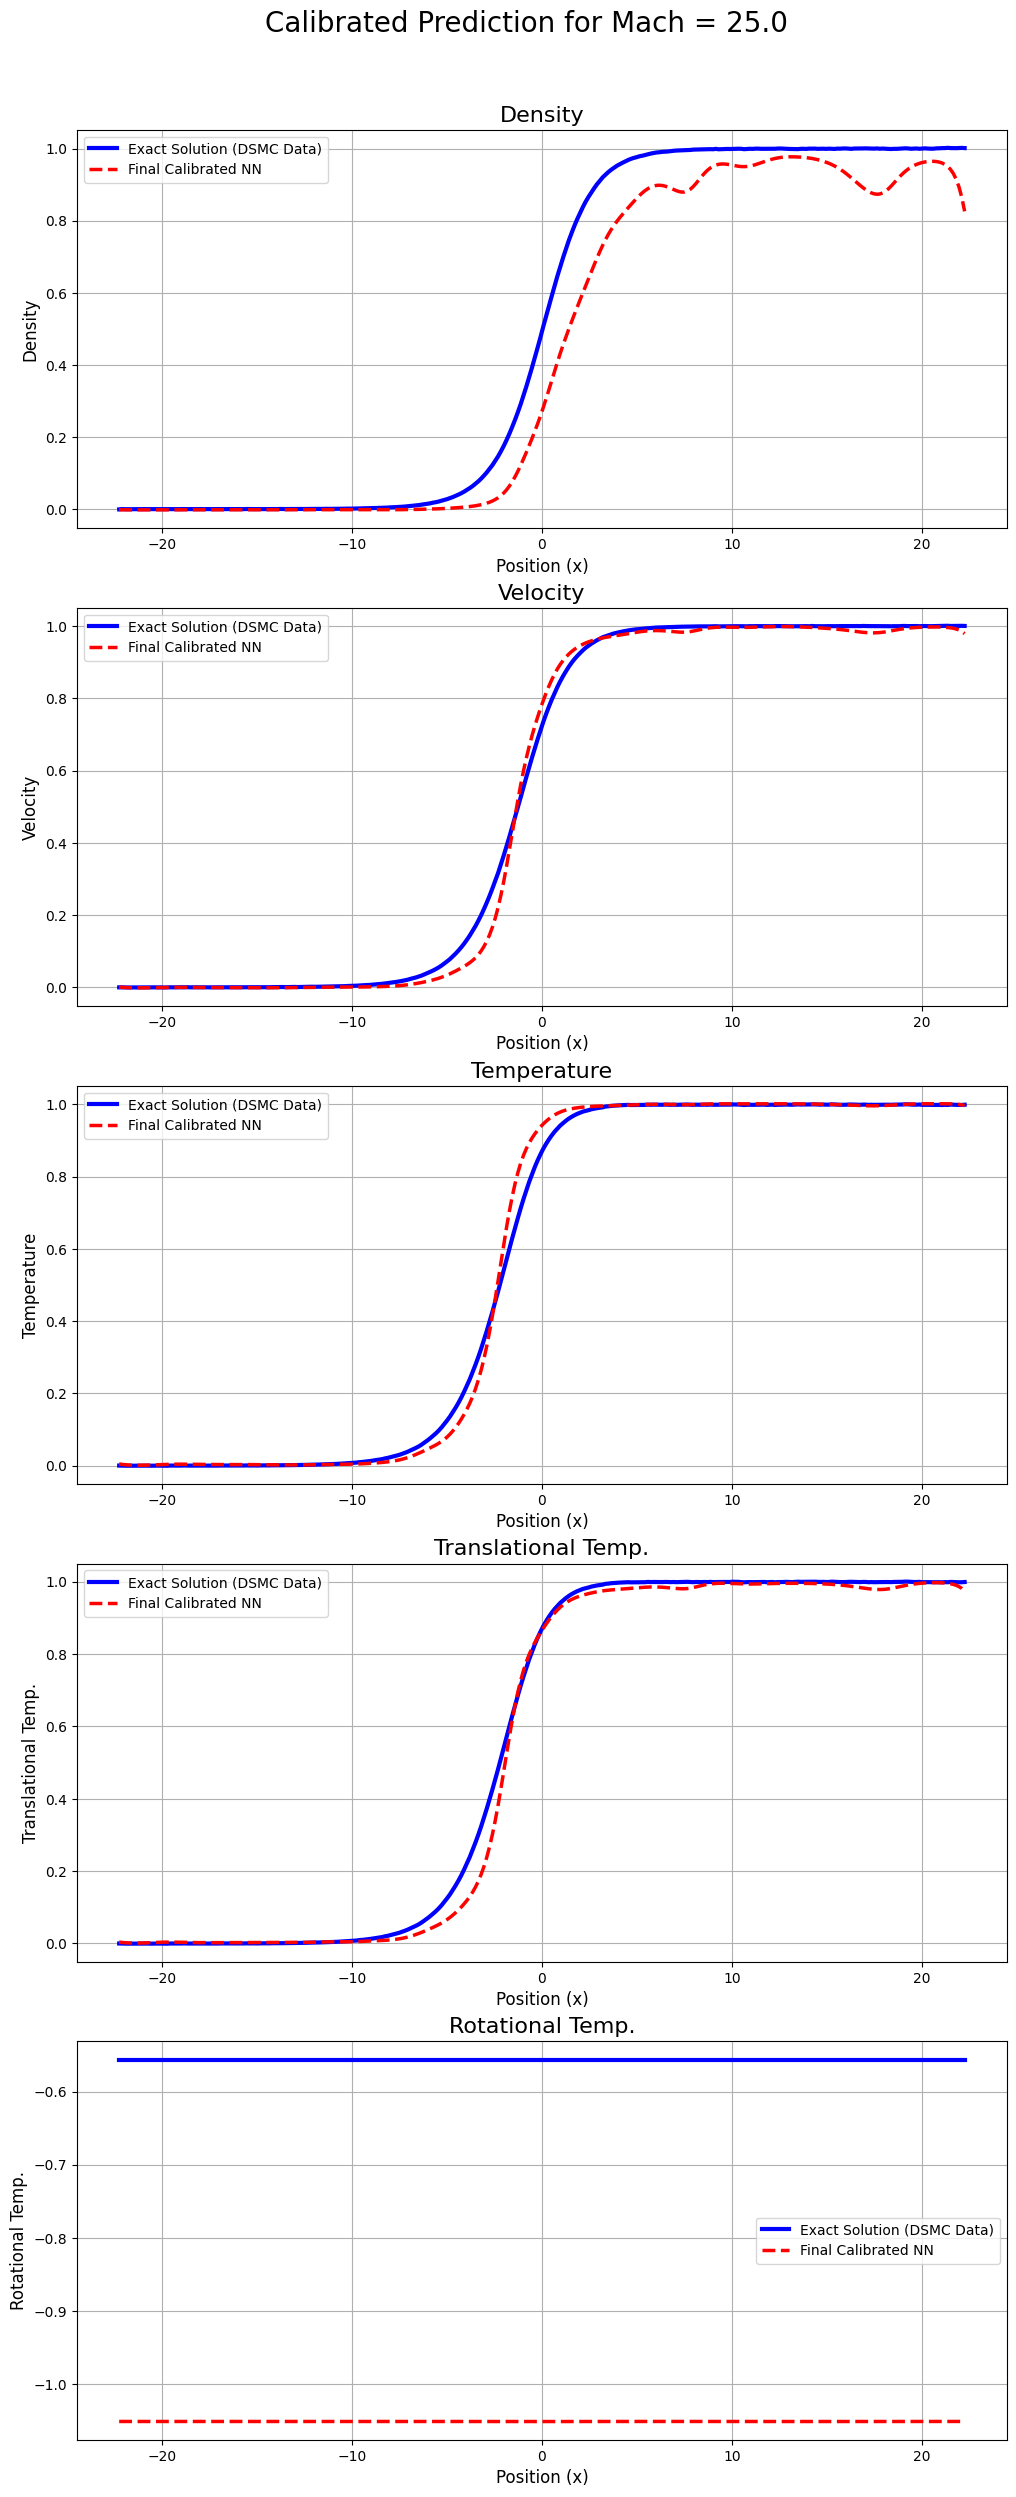

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2

# --- 1. Fourier Feature Layer with Final Tuned Scale ---
# FINAL CALIBRATION: The optimal value for scale is between 2.5 and 5.0. Let's try 4.0.
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=4.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_file = 'M25.txt'

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            return None, None, None
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")

# --- 4. The Proven Architecture: Concatenate + Heavy Regularization ---
L2_LAMBDA = 1e-6

pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

fourier_layer = FourierFeatures(output_dims=256)(pos_input)
concatenated_input = layers.concatenate([fourier_layer, mach_input])

x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(concatenated_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(5, activation='sigmoid')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nTraining the final, calibrated model...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=4000,
    validation_split=0.2,
    verbose=1,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)
    ]
)
print("Training finished.")

# --- 6. Final Evaluation for Mach 25 ---
print("\n--- Final Extrapolation Evaluation for Mach 25 ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

x_test, y_test, mach_test = load_data([extrapolation_file], DATASET_PATH)
if x_test is not None:
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Calibrated Prediction for Mach = 25.0', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', linewidth=3, label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', linewidth=2.5, label='Final Calibrated NN')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Preparing data and calculating derivatives for slope-aware training...


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_10 │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 257)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 256)       │     66,048 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 256)       │          0 │ dense_58[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 256)       │     65,792 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 256)       │          0 │ dense_59[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 256)       │     65,792 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 256)       │          0 │ dense_60[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 256)       │     65,792 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 256)       │          0 │ dense_61[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value_output        │ (None, 5)         │      1,285 │ dropout_20[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ derivative_output   │ (None, 5)         │      1,285 │ dropout_20[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 10)        │          0 │ value_output[0][… │
│ (Concatenate)       │                   │            │ derivative_outpu… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 266,122 (1.02 MB)

 Trainable params: 266,122 (1.02 MB)

 Non-trainable params: 0 (0.00 B)


Starting definitive training with slope-aware loss...
Epoch 1/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.6224 - val_loss: 0.5533 - learning_rate: 1.0000e-04
Epoch 2/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5526 - val_loss: 0.5074 - learning_rate: 1.0000e-04
Epoch 3/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4629 - val_loss: 0.4552 - learning_rate: 1.0000e-04
Epoch 4/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4420 - val_loss: 0.3940 - learning_rate: 1.0000e-04
Epoch 5/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3984 - val_loss: 0.3224 - learning_rate: 1.0000e-04
Epoch 6/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2956 - val_loss: 0.2475 - learning_rate: 1.0000e-04
Epoch 7/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2999 - val_loss: 0.1867 - learning_rate: 1.0000e-04
Epoch 8/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2320 - val_loss: 0.1558 - learning_rate: 1.0000e-04
Epoch 9/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 

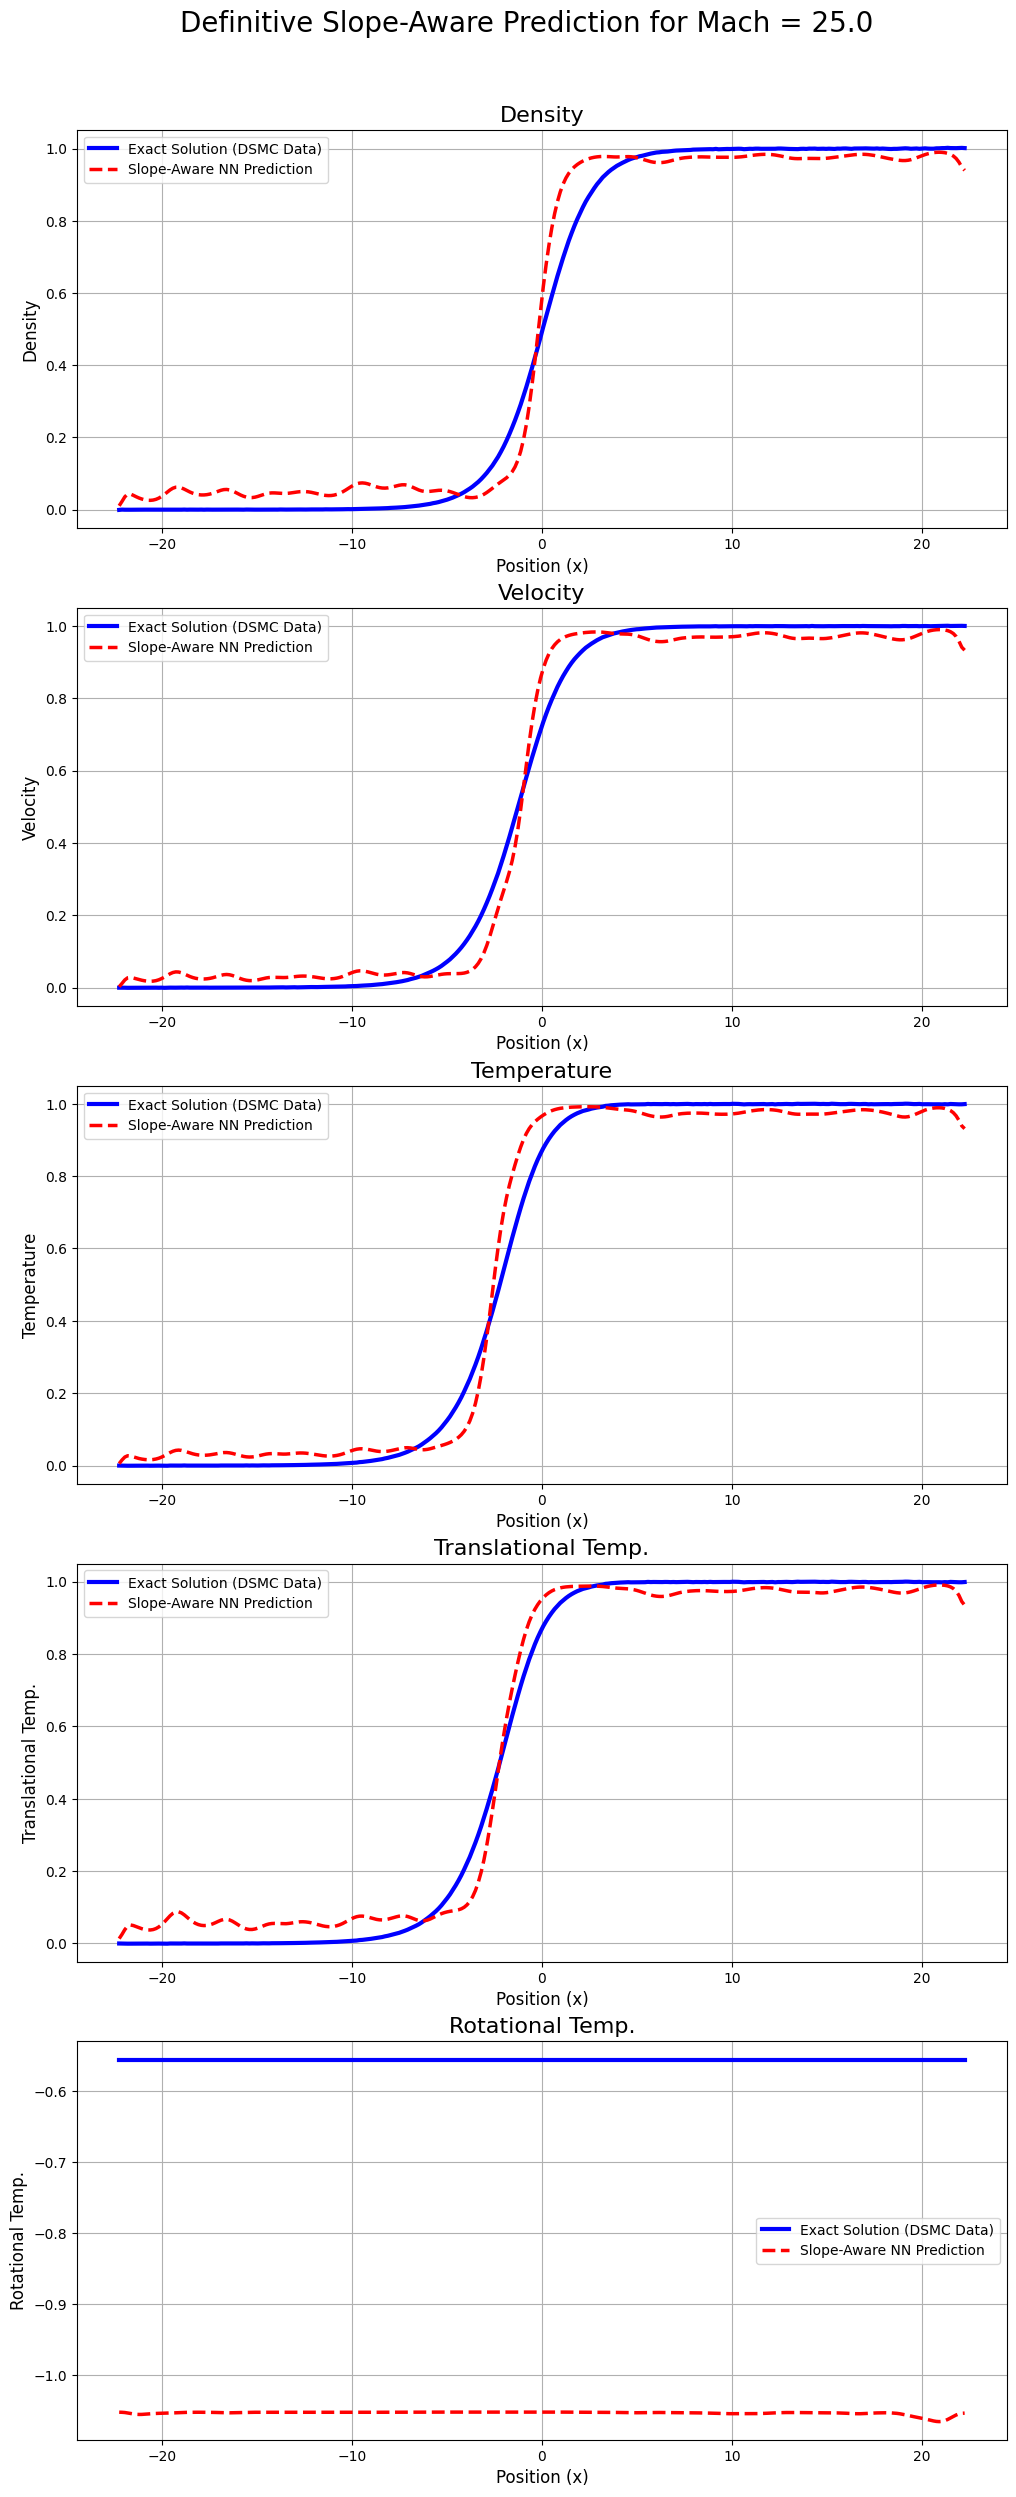

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2

# --- 1. Fourier Feature Layer ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=5.0): # Back to the best scale
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_file = 'M25.txt'

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            return None, None, None
        data = np.loadtxt(full_path)
        # Sort data by position to calculate gradients correctly
        sort_indices = np.argsort(data[:, 0])
        x_data.append(data[sort_indices, 0])
        y_data.append(data[sort_indices, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Feature & Target Engineering ---
print("Preparing data and calculating derivatives for slope-aware training...")

# Calculate derivatives of y with respect to x for the training data
dy_dx_train = np.gradient(y_train, x_train.flatten(), axis=0)

# Scalers
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()
dydx_scaler = StandardScaler() # Use a separate scaler for derivatives

# Scale position and Mach number
x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)

# Scale original y and new dy/dx targets
y_train_scaled = y_scaler.fit_transform(y_train)
dydx_train_scaled = dydx_scaler.fit_transform(dy_dx_train)

# Combine targets: [y0..y4, dy/dx0..dy/dx4]
y_combined_train_scaled = np.concatenate([y_train_scaled, dydx_train_scaled], axis=1)

# --- 4. Model for Predicting Values AND Slopes ---
# The model now outputs 10 values instead of 5
L2_LAMBDA = 1e-6

pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

fourier_layer = FourierFeatures(output_dims=256)(pos_input)
concatenated_input = layers.concatenate([fourier_layer, mach_input])

x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(concatenated_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)

# The output layer is now twice as wide.
# The first 5 neurons predict the scaled values (needs sigmoid)
# The next 5 neurons predict the scaled derivatives (needs linear)
output_values = layers.Dense(5, activation='sigmoid', name='value_output')(x)
output_derivs = layers.Dense(5, activation='linear', name='derivative_output')(x)
combined_output = layers.concatenate([output_values, output_derivs])

model = keras.Model(inputs=[pos_input, mach_input], outputs=combined_output)

# The loss function is still MSE, but now it applies to the combined vector of values and derivatives
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')
model.summary()

# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}
print("\nStarting definitive training with slope-aware loss...")
history = model.fit(
    train_inputs,
    y_combined_train_scaled, # Train on the combined target
    epochs=4000,
    validation_split=0.2,
    verbose=1,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)
    ]
)
print("Training finished.")

# --- 6. Final Evaluation for Mach 25 ---
print("\n--- Final Extrapolation Evaluation for Mach 25 ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

x_test, y_test, mach_test = load_data([extrapolation_file], DATASET_PATH)
if x_test is not None:
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}

    # The model predicts a vector of 10
    y_combined_pred_scaled = model.predict(test_inputs)

    # We only need the first 5 for plotting the values
    y_pred_scaled = y_combined_pred_scaled[:, :5]
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Definitive Slope-Aware Prediction for Mach = 25.0', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', linewidth=3, label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', linewidth=2.5, label='Slope-Aware NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data...
Normalization successful.


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_11 │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 257)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 256)       │     66,048 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ dense_62[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 256)       │     65,792 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 256)       │          0 │ dense_63[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 256)       │     65,792 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 256)       │          0 │ dense_64[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 256)       │     65,792 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 256)       │          0 │ dense_65[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 5)         │      1,285 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 264,837 (1.01 MB)

 Trainable params: 264,837 (1.01 MB)

 Non-trainable params: 0 (0.00 B)


Training the final, most robust model...
Epoch 1/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.1819 - val_loss: 0.2138 - learning_rate: 1.0000e-04
Epoch 2/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1734 - val_loss: 0.2053 - learning_rate: 1.0000e-04
Epoch 3/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1635 - val_loss: 0.1948 - learning_rate: 1.0000e-04
Epoch 4/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1532 - val_loss: 0.1817 - learning_rate: 1.0000e-04
Epoch 5/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1399 - val_loss: 0.1648 - learning_rate: 1.0000e-04
Epoch 6/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1210 - val_loss: 0.1435 - learning_rate: 1.0000e-04
Epoch 7/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1010 - val_loss: 0.1188 - learning_rate: 1.0000e-04
Epoch 8/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0795 - val_loss: 0.0936 - learning_rate: 1.0000e-04
Epoch 9/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - l

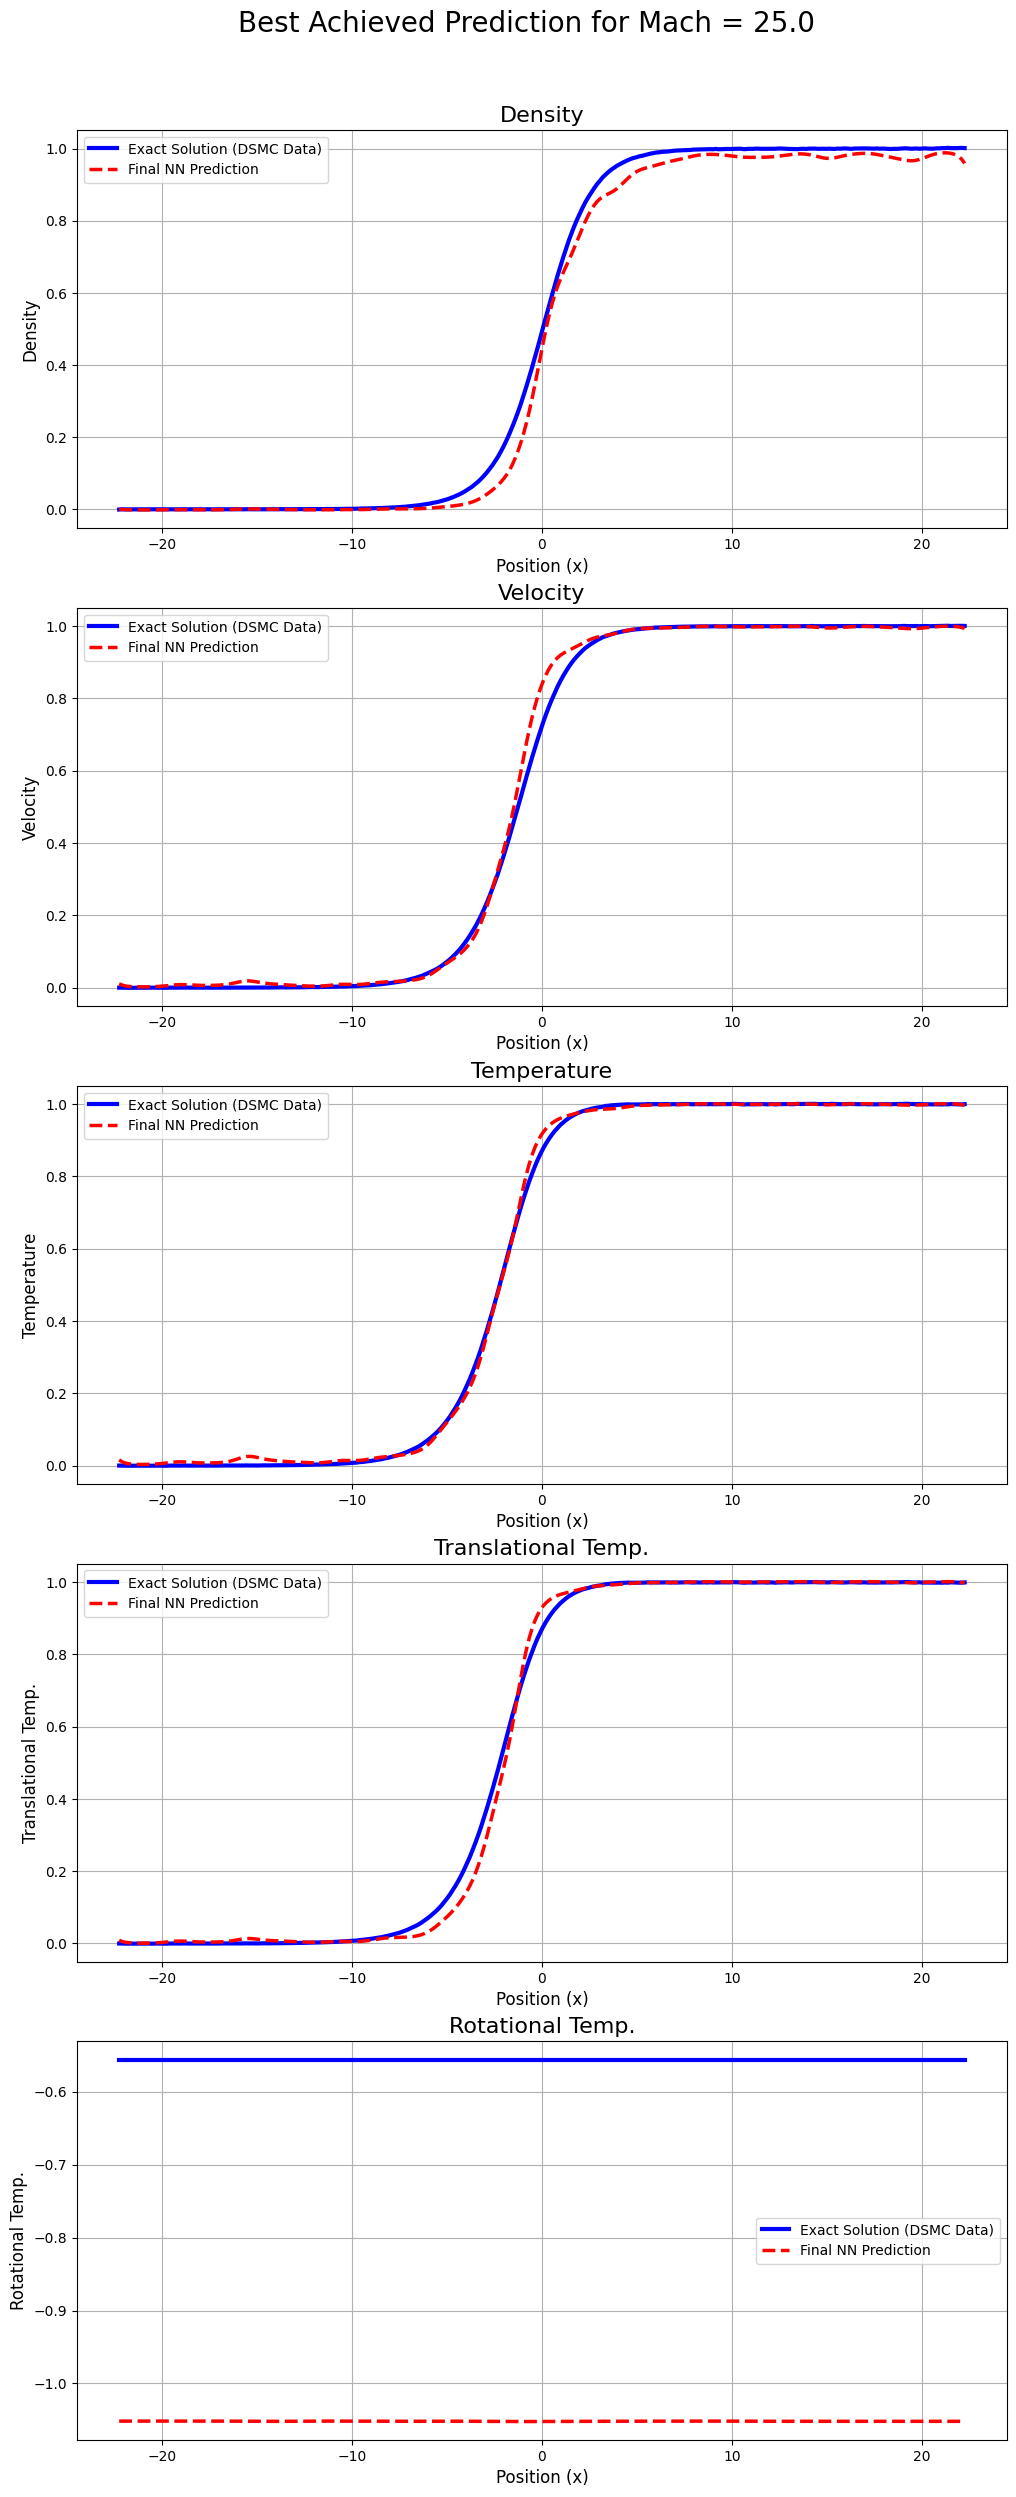

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2

# --- 1. Learnable Fourier Feature Layer with the best performing scale ---
class FourierFeatures(layers.Layer):
    # Returning to scale=5.0 which gave the best result.
    def __init__(self, output_dims, scale=5.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_file = 'M25.txt'

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            return None, None, None
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")

# --- 4. The Proven Architecture: Concatenate + Heavy Regularization ---
L2_LAMBDA = 1e-6

pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

fourier_layer = FourierFeatures(output_dims=256)(pos_input)
concatenated_input = layers.concatenate([fourier_layer, mach_input])

x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(concatenated_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(5, activation='sigmoid')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nTraining the final, most robust model...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=4000,
    validation_split=0.2,
    verbose=1,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)
    ]
)
print("Training finished.")

# --- 6. Final Evaluation for Mach 25 ---
print("\n--- Final Extrapolation Evaluation for Mach 25 ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

x_test, y_test, mach_test = load_data([extrapolation_file], DATASET_PATH)
if x_test is not None:
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Best Achieved Prediction for Mach = 25.0', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', linewidth=3, label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', linewidth=2.5, label='Final NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()

Loading training data...
Normalizing data...
Normalization successful.


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_12 │ (None, 256)       │        128 │ position[0][0]    │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mach (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 257)       │          0 │ fourier_features… │
│ (Concatenate)       │                   │            │ mach[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 256)       │     66,048 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 256)       │          0 │ dense_67[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 256)       │     65,792 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 256)       │          0 │ dense_68[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 256)       │     65,792 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 256)       │          0 │ dense_69[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 256)       │     65,792 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 256)       │          0 │ dense_70[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 5)         │      1,285 │ dropout_28[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 264,837 (1.01 MB)

 Trainable params: 264,837 (1.01 MB)

 Non-trainable params: 0 (0.00 B)


Training the final, reproducible model...
Epoch 1/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.1812 - val_loss: 0.2117 - learning_rate: 1.0000e-04
Epoch 2/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1725 - val_loss: 0.2028 - learning_rate: 1.0000e-04
Epoch 3/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1637 - val_loss: 0.1922 - learning_rate: 1.0000e-04
Epoch 4/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1525 - val_loss: 0.1791 - learning_rate: 1.0000e-04
Epoch 5/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1401 - val_loss: 0.1625 - learning_rate: 1.0000e-04
Epoch 6/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1233 - val_loss: 0.1421 - learning_rate: 1.0000e-04
Epoch 7/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1046 - val_loss: 0.1189 - learning_rate: 1.0000e-04
Epoch 8/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0831 - val_loss: 0.0956 - learning_rate: 1.0000e-04
Epoch 9/4000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - 

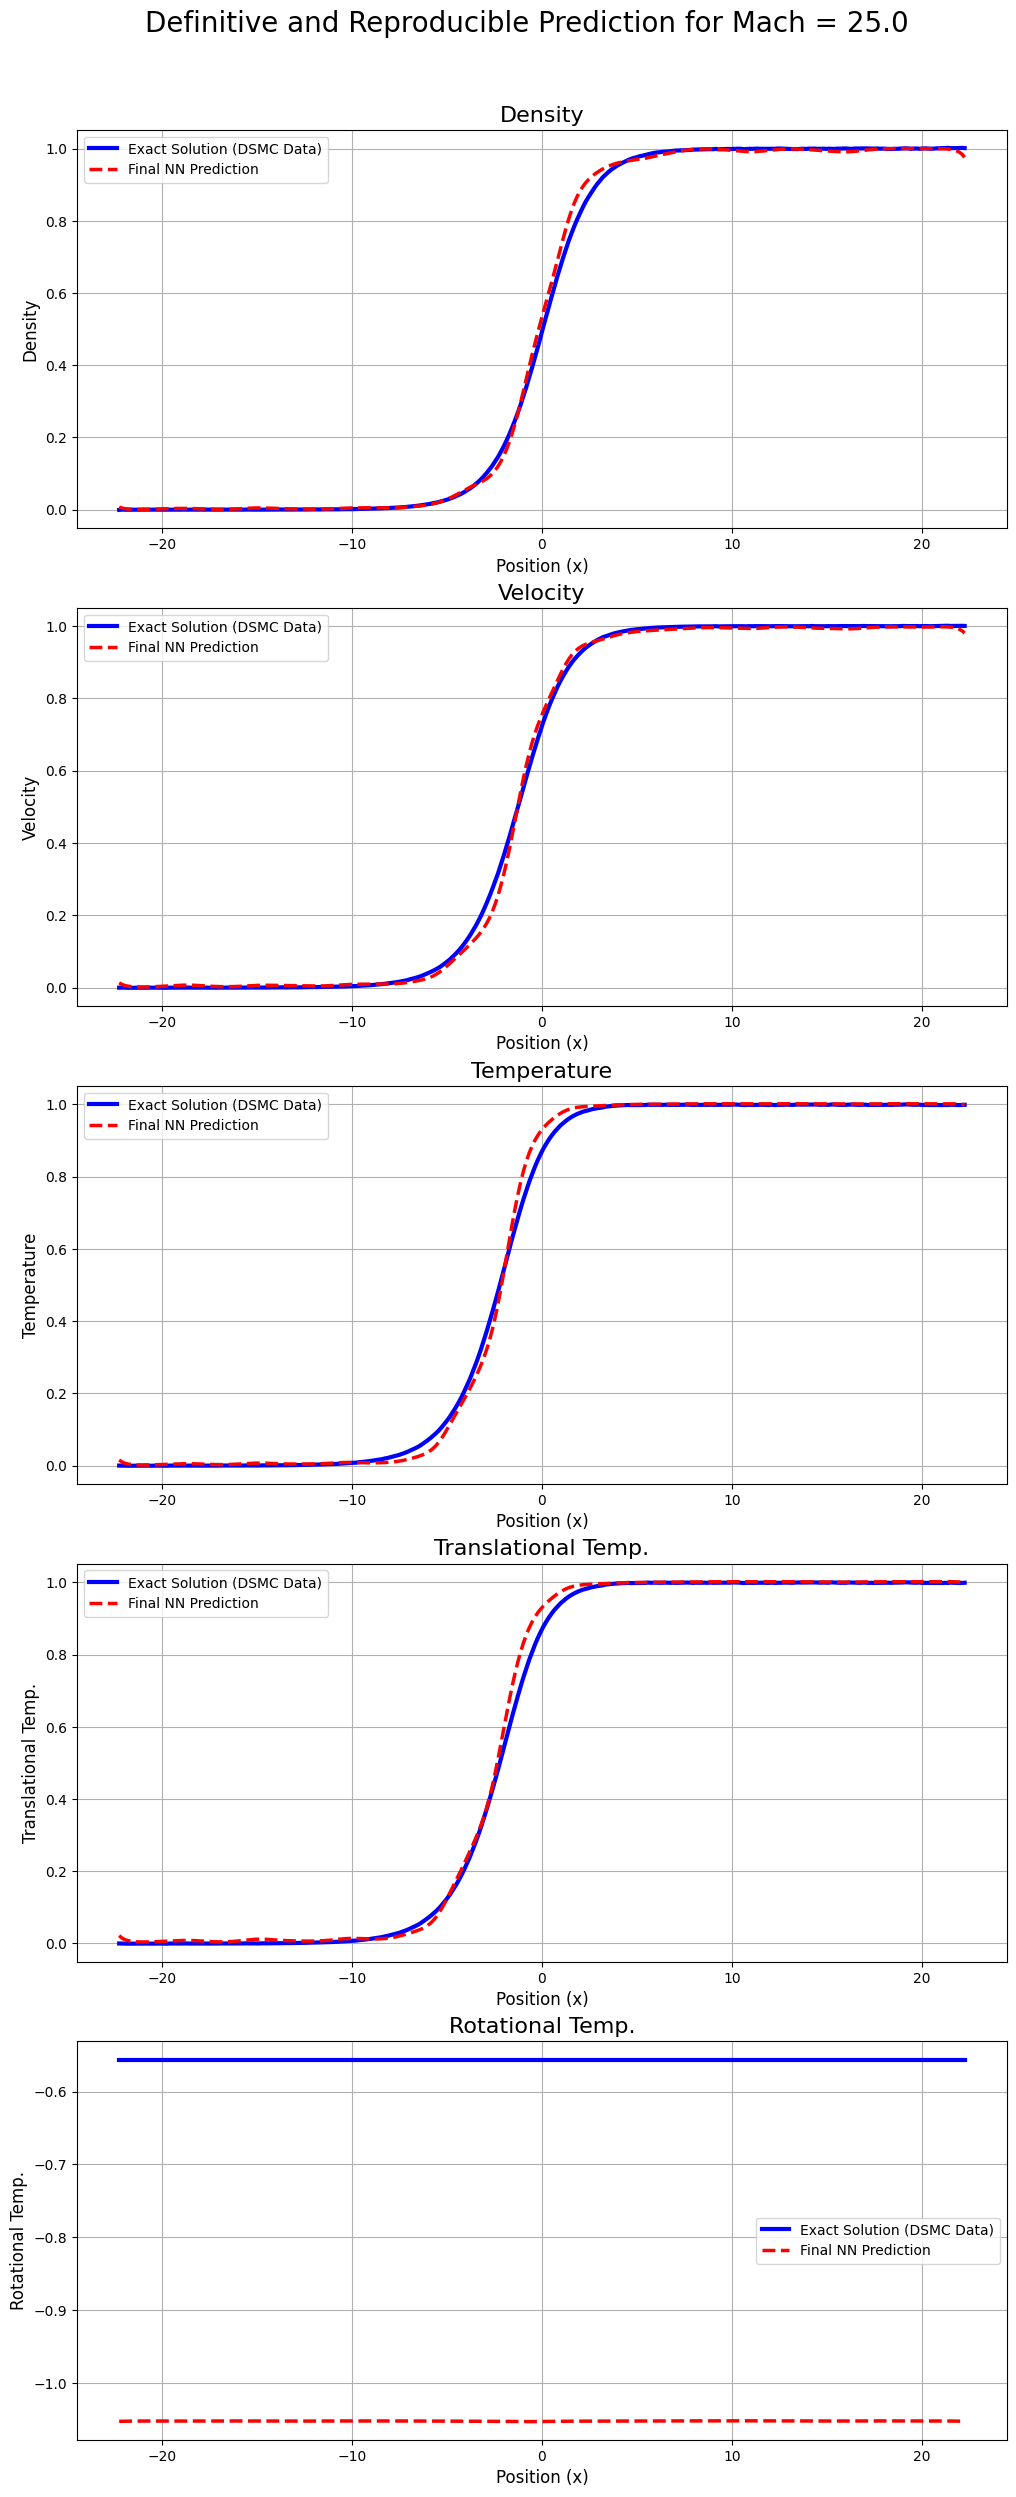

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2
import random

# --- FINAL STEP: Set Random Seeds for Reproducibility ---
# This ensures that every run of the code produces the exact same result.
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


# --- 1. Learnable Fourier Feature Layer with the best performing scale ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=5.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        self.B = self.add_weight(name='B',
                                 shape=[1, self.output_dims // 2],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- 2. Data Loading ---
DATASET_PATH = './'
train_files = ['M14.txt', 'M15.txt', 'M16.txt', 'M17.txt', 'M18.txt', 'M19.txt']
extrapolation_file = 'M25.txt'

def load_data(files, path):
    x_data, y_data, mach_data = [], [], []
    for file_name in files:
        mach_number = float(file_name.replace('M', '').replace('.txt', ''))
        full_path = os.path.join(path, file_name)
        if not os.path.exists(full_path):
            print(f"Warning: Data file not found at {full_path}. Skipping.")
            return None, None, None
        data = np.loadtxt(full_path)
        x_data.append(data[:, 0])
        y_data.append(data[:, 1:6])
        mach_data.append(np.full(data.shape[0], mach_number))
    return np.concatenate(x_data), np.concatenate(y_data, axis=0), np.concatenate(mach_data)

print("Loading training data...")
x_train, y_train, mach_train = load_data(train_files, DATASET_PATH)
x_train = x_train.reshape(-1, 1)
mach_train = mach_train.reshape(-1, 1)

# --- 3. Normalization ---
print("Normalizing data...")
pos_scaler = MinMaxScaler()
mach_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_train_scaled = pos_scaler.fit_transform(x_train)
mach_train_scaled = mach_scaler.fit_transform(mach_train)
y_train_scaled = y_scaler.fit_transform(y_train)
print("Normalization successful.")

# --- 4. The Proven Architecture: Concatenate + Heavy Regularization ---
L2_LAMBDA = 1e-6

pos_input = keras.Input(shape=(1,), name='position')
mach_input = keras.Input(shape=(1,), name='mach')

fourier_layer = FourierFeatures(output_dims=256)(pos_input)
concatenated_input = layers.concatenate([fourier_layer, mach_input])

x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(concatenated_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish', kernel_regularizer=l2(L2_LAMBDA))(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(5, activation='sigmoid')(x)

model = keras.Model(inputs=[pos_input, mach_input], outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 5. Training ---
train_inputs = {'position': x_train_scaled, 'mach': mach_train_scaled}

print("\nTraining the final, reproducible model...")
history = model.fit(
    train_inputs,
    y_train_scaled,
    epochs=4000,
    validation_split=0.2,
    verbose=1,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)
    ]
)
print("Training finished.")

# --- 6. Final Evaluation for Mach 25 ---
print("\n--- Final Extrapolation Evaluation for Mach 25 ---")
output_labels = ['Density', 'Velocity', 'Temperature', 'Translational Temp.', 'Rotational Temp.']

x_test, y_test, mach_test = load_data([extrapolation_file], DATASET_PATH)
if x_test is not None:
    x_test = x_test.reshape(-1, 1)
    mach_test = mach_test.reshape(-1, 1)

    x_test_scaled = pos_scaler.transform(x_test)
    mach_test_scaled = mach_scaler.transform(mach_test)

    test_inputs = {'position': x_test_scaled, 'mach': mach_test_scaled}
    y_pred_scaled = model.predict(test_inputs)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    fig, axes = plt.subplots(5, 1, figsize=(12, 30))
    fig.suptitle(f'Definitive and Reproducible Prediction for Mach = 25.0', fontsize=20, y=0.92)

    for i in range(5):
        ax = axes[i]
        sort_indices = np.argsort(x_test.flatten())
        ax.plot(x_test[sort_indices], y_test[sort_indices, i], 'b-', linewidth=3, label='Exact Solution (DSMC Data)')
        ax.plot(x_test[sort_indices], y_pred[sort_indices, i], 'r--', linewidth=2.5, label='Final NN Prediction')
        ax.set_title(output_labels[i], fontsize=16)
        ax.set_xlabel('Position (x)', fontsize=12)
        ax.set_ylabel(output_labels[i], fontsize=12)
        ax.legend()
        ax.grid(True)
    plt.show()
